# Effects of Cyclone Yasi on Green Cover Fraction at Mission Beach

This tutorial is part of TERN's (Terrestrial Ecology Research Network) DSDP (Data Skills Development Program). In it we will explore the effect of Cyclone Yasi on the green vegetation fraction in Djiru National Park at the backdrop of Mission Beach. In the process we will explain and familiarise with the use of remote sensing data (particularly TERN's data) in R. Detailed information on how to use raster data in R can be found in TERN's DSDP *"Using Raster Data in R"* tutorial. Additional examples of the usage of TERN's Remote Sensing data can be found in TERN's DSDP *"Green Vegetation Temporal Dynamics: Monitoring and Analysis using NDVI and Fractional Cover TERN rasters (Parts 1 & 2)"* tutorials.

Cyclone Yasi was a large and severe cyclone that crossed the coastline near Mission Beach on February 3, 2011. It destroyed ~30% of the houses in Tully, decimated the banana and sugar cane industries (75% of the banana crops were destroyed). Its was so powerful and large that it only weakened to a tropical low near Mount Isa, ~800 km inland, over 20 hours after making landfall. 

To investigate the effect of cyclone Yasi on the green vegetation do so we will compare Remote Sensing images taken before and after the cyclone landfall over the Djiru National Park at the backdrop of Mission Beach. Specifically we will compare seasonal image composites of the two types of TERN's remote sensing fractional cover data, Persistent Green Cover & Green Ground Cover, for the Winters (June to August) of 2010 and 2011. 

Seasonal persistent green cover estimates the portion of vegetation that does not completely senesce within a year, which primarily consists of woody vegetation (trees and shrubs). Seasonal Green Ground Cover estimates of 'true' green ground cover for each season, restricted to areas of less than 60% woody vegetation, by combining information from the Seasonal Persistent Green and Seasonal Fractional Cover products.  


## Preparation: Getting ready

We start by loading the required libraries, setting up a working directory, and cleaning up memory. If you haven't installed the required R libraries yet, have a look at the accompaning README.txt file for details on how to do this. 


In [1]:
#************************************************************************************************************************
# Set Up: Getting ready
#************************************************************************************************************************

#========================================================================================================================
# Load  Libraries
#========================================================================================================================

library(sp)  # Classes and methods for spatial data (the classes document where the spatial location information resides, for 2D or 3D data).
library(rgdal) # Bindings to Geospatial Data Abstraction Library ('GDAL') and access to projection/transformation operations from 'PROJ.4' library. 
#library(geojsonio) # Converts data to 'GeoJSON' or'TopoJSON' from various R classes (vectors, lists, data frames, shape files, and spatial classes). 
library(raster) # Reading, writing, manipulating, analyzing and modeling of gridded spatial data.
library(RStoolbox) # Toolbox for remote sensing image processing and analysis (here for function 'normImage').

library(ggmap) # To visualize spatial data (and models) on top of static maps from various online sources
library(rasterVis) # Methods for enhanced visualization and interaction with raster data.

library(RColorBrewer) # Color schemes for maps (and other graphics).
library(ggplot2) # A system for 'declaratively' creating graphics, based on "The Grammar of Graphics".
library(gridExtra) # Functions to work with "grid" graphics (here to arrange multiple grid-based plots on a page).

library(reshape2) # Flexibly restructure and aggregate data using just two functions: 'melt' and 'dcast' (or 'acast'). Here for function 'melt'


#========================================================================================================================
# Optional Steps (remove comments to run them)
#========================================================================================================================

# Setting up my Current Working Directory
# ---------------------------------------
#getwd()
#my.CWDir = "C:/Users/uqbblanc/Documents/TERN/CWDir"  # Replace with your Working Directory
#setwd(my.CWDir)
#getwd()

# Clean up Memory
# ---------------
#rm(list=ls())
#list.files()


Warning message:
"package 'rgdal' was built under R version 3.5.3"rgdal: version: 1.4-3, (SVN revision 828)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.2.3, released 2017/11/20
 Path to GDAL shared files: C:/Users/uqbblanc/Documents/R/R-3.5.1/library/rgdal/gdal
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
 Path to PROJ.4 shared files: C:/Users/uqbblanc/Documents/R/R-3.5.1/library/rgdal/proj
 Linking to sp version: 1.3-1 
Warning message:
"package 'raster' was built under R version 3.5.3"Warning message:
"package 'RStoolbox' was built under R version 3.5.3"Warning message:
"package 'ggmap' was built under R version 3.5.3"Loading required package: ggplot2
Google's Terms of Service: https://cloud.google.com/maps-platform/terms/.
Please cite ggmap if you use it! See citation("ggmap") for details.
Loading required package: lattice
Loading required package: latticeExtra
Load

## Region & Study Area: Finding our bearings

We will start by creating a Map of the Region & Study Area that where we will focus in the workshop. We first retrieve a map for the region from a server and plot it. They we will create and plot a polygon (i.e. red square) repressing the study area. This will also allow us to provide an introduction to Coordinate Reference Systems (CRSs) in R.  

We will use the functions in the package `ggmap` to query map servers for a map and plot the map. The function `get_map` in this package can query Google Maps, Naver Maps, OpenStreeMap, and Stamen Maps. Unfortunately, since July 2018 to download maps from Google Maps (and Naver Maps) an Application Program Interface (API) Key is required. Registration to obtain this key involves providing a credit card number. Light usage have no charge to a modest charge. More information can be found in the ['ggmap' GitHub pages](https://github.com/dkahle/ggmap) and [Google developers pages](https://developers.google.com/maps/documentation/geocoding/usage-and-billing). Fortunately, we can freely download maps from Stamen. 

`get_map` is a smart wrapper that queries the Google Maps, OpenStreetMap, Stamen Maps or Naver Map servers for a map. To retrieve a map it requires a bounding box (xmin, ymin, xmax, ymax), a longitude/latitude pair, or an address. `Bounding boxes` are similar to the `extents` describing rasters in R, but with their elements arrange in different order (xmin, xmax, ymin, ymax in `extent`). `get_map` retrieves maps in geographic coordinates (latitude/longitude) on the World geodetic System of 1984 (WGS84) datum. 

To plot a polygon with the Study Area we create the required spatial extent and convert it to a polygon. This polygon does not have a CRS, so we provide an appropriate one. CRS can be stored in many different formats. The most common ones include: *PROJ.4* (the default output from many spatial data R packages; e.g. `sp`, `rgdal`, `raster`); *EPSG codes*, (a more concise format, found for example in the package `sf`); and *Well Known Text (WKT)* format. For more details on CRS and their formats, see TERN DSDP **\"Using Raster Data in R\"** tutorial. The EPSG format for geographic coordinates on the WGS84 datum is EPSG:4326. This is a general spatial reference (i.e. area: World; scope: Horizontal component of 3D system). It is used by GPS satellite navigation system and NATO military geodetic surveying). For more details see this [spatialreferece.org link](https://spatialreference.org/ref/epsg/wgs-84/). 

The function `ggmap` from the `ggmap` package plots the raster objects produced by `get_map`. `ggmap` is built 'on top' the `ggplot2` graphic library framework, and therefore it can use elements/features of this library. This allows us to use the `ggplot2` function `geom_polygon` to add to the plot a red square representing the Study Area. 

Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.


class       : SpatialPolygons 
features    : 1 
extent      : 146.0333, 146.0833, -17.9333, -17.8583  (xmin, xmax, ymin, ymax)
coord. ref. : NA 

class       : SpatialPolygons 
features    : 1 
extent      : 146.0333, 146.0833, -17.9333, -17.8583  (xmin, xmax, ymin, ymax)
coord. ref. : +init=epsg:4326 +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0 

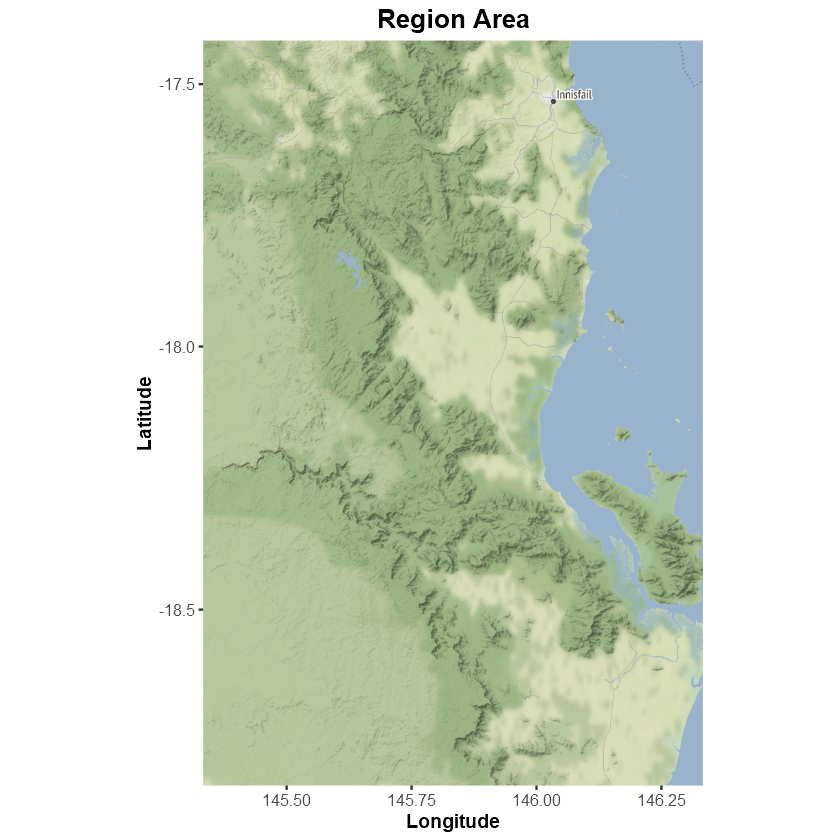

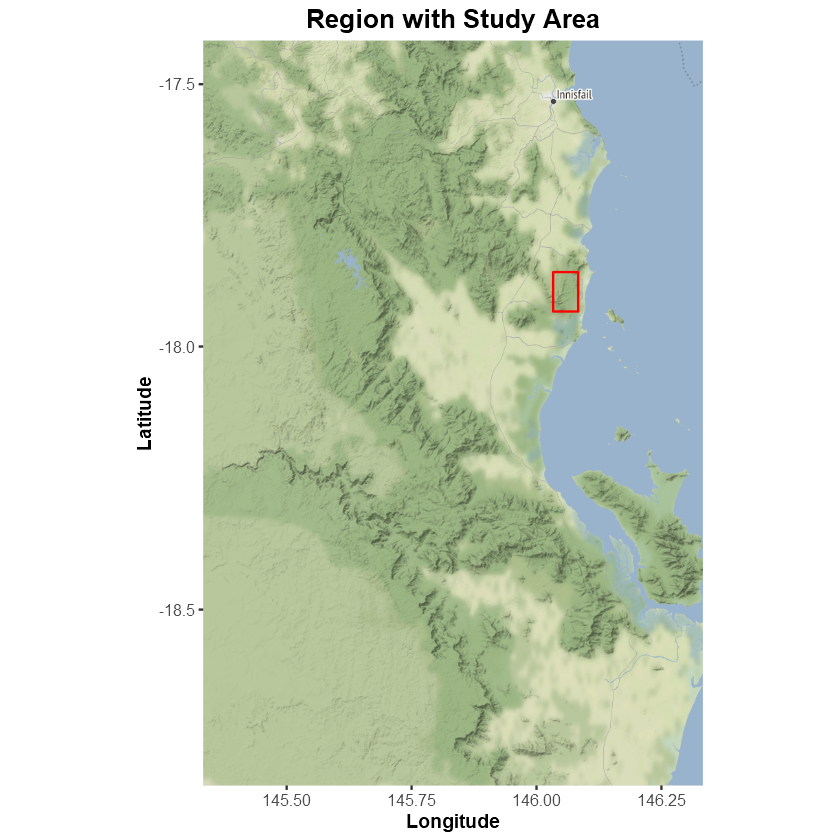

In [2]:
#************************************************************************************************************************
# Region & Study Area: Finding our bearings
#************************************************************************************************************************


#========================================================================================================================
# Region
#========================================================================================================================

# Define Extent of Region: Innisfail to Ingham
# --------------------------------------------
RegionArea.extent = extent(145.333, 146.333, -18.8333, -17.4167)

# Get Map 
# -------
# get_stamenmap requires the coordinates in a different order than the extent construction
RegionArea.StamenMap = get_stamenmap(RegionArea.extent[c(1,3,2,4)], maptype="terrain")

# Create Plot of the Map
# ----------------------
# Stamen map of this area is not very detailed
RegionArea.p = 
ggmap(RegionArea.StamenMap) + labs(title= "Region Area", x="Longitude", y="Latitude") +
theme(plot.title = element_text(hjust = 0.5, size=15, face="bold"), 
      axis.title = element_text(size=11, face="bold"), axis.text=element_text(size=9) )
RegionArea.p  


#========================================================================================================================
# Study Area
#========================================================================================================================

# Define Spatial 'Extent' of Study Area: Mission Beach backdrop
# --------------------------------------------------------------
StudyArea.extent = extent(146.0333, 146.0833, -17.9333, -17.8583)

# Create a working spatial structure from the spatial 'Extent'
# ------------------------------------------------------------
# Create a 'Spatial Polygon' from Spatial 'Extent'
StudyArea.SP = as(StudyArea.extent, "SpatialPolygons")
StudyArea.SP # Has not CRS
# Add a CRS. Use: EPSG:4326 = 'WGS84' - General Spatial Reference (https://spatialreference.org/ref/epsg/wgs-84/).
proj4string(StudyArea.SP) = CRS("+init=epsg:4326") # Add CRS
StudyArea.SP # Has a EPSG:4326 CRS

# Create plot of the Map with the Study Area
# ------------------------------------------
# Note that the 'title' has been updated in the process of creating the new plot
RegionwStudyArea.p = RegionArea.p + labs(title = "Region with Study Area") +
                     geom_polygon(data=StudyArea.SP, aes(x=long, y=lat), color="red", alpha=0)
RegionwStudyArea.p


## Seasonal Persistent Green Cover (SPGC)

### Download Data

To download a file for the Internet we use the function `download.file` from the package `utils`. This package comes standard with the R installation.

This function takes 3 main arguments (among others):

* `url`: A character string (or longer vector in some methods, e.g. "libcurl" method) naming the URL of a resource to be downloaded.
* `destfile`: A character string (or vector, see url) with the name where the downloaded file is saved.
* `method`: Method to be used for downloading files. Current download methods are "internal", "wininet" (Windows only) "libcurl", "wget", "curl", and "auto".

We use the method `auto`, which usually performs well. If it would work we could try another method (e.g. `wget`) or use the functions in the `RCurl` library (not included in the R installation).

In [3]:
SPGC.URL = "http://qld.auscover.org.au/public/data/landsat/seasonal_fractional_cover/persistent_green/aus/"
SPGC.2010q3.fn = "lztmre_aus_m201006201008_djaa2.vrt"
SPGC.2011q3.fn = "lztmre_aus_m201106201108_djaa2.vrt"
SPGC.TS.fn = "lztmre_aus_s198912201611_djaa2_persistent.vrt"

# Download the data files (if it doesn't work try method='wget' or functions in Library 'RCurl')
download.file(url=paste(SPGC.URL, SPGC.2010q3.fn, sep="/"), destfile='SPGC_2010q3.vrt', method='auto')
download.file(url=paste(SPGC.URL, SPGC.2011q3.fn, sep="/"), destfile='SPGC_2011q3.vrt', method='auto')
download.file(url=paste(SPGC.URL, SPGC.TS.fn, sep="/"), destfile='SPGC_TS.vrt', method='auto')
list.files()


[1] "JNb_YasiEffectsonGCatMB_Tutorial.html" 
 [2] "JNb_YasiEffectsonGCatMB_Tutorial.ipynb"
 [3] "JNb_YasiEffectsonGCatMB_Tutorial.pdf"  
 [4] "README.md"                             
 [5] "SGC_StudyArea_Res.grd"                 
 [6] "SGC_StudyArea_Res.gri"                 
 [7] "SGC_StudyArea_Res.hdr"                 
 [8] "SGC_StudyArea_Res.nc"                  
 [9] "SGC_StudyArea_Res.stx"                 
[10] "SGGC_TS.vrt"                           
[11] "SPGC_2010q3.vrt"                       
[12] "SPGC_2011q3.vrt"                       
[13] "SPGC_TS.vrt"                           
[14] "YasiEffectsonGCatMB._Tutorial.html"    
[15] "YasiEffectsonGCatMB._Tutorial.Rmd"     
[16] "YasiEffectsonGCatMB._Tutorial_files"   
[17] "YasiEffectsonGCatMB_Tutorial.pdf"      
[18] "YasiEffectsonGCatMB_Tutorial.r"

### Load Data

A `raster` is a spatial (geographic) data structure that divides the space into elements of equal size (in units of the coordinate reference system) called `cells`. Cells have a square or rectangular shape and can store one or more values. Raster are also sometimes referred to as `grids` and cells as `pixels`. 

The fundamental R package for working with spatial data in raster format is `raster`, originally developed by Robert J. Hijmans. A notable feature of this package is that it can work with very large spatial datasets that cannot be loaded into computer memory. Functions process these large datasets in chunks, without attempting to load all values into memory at once. 
   
The `raster` package creates and uses objects of several new classes. The main new classes provided by this package are: `RasterLayer`, `RasterStack`, and `RasterBrick`. Objects in these three classes are collectively referred as `Raster*` objects. 

* `RasterLayer`: Object containing a single-layer raster. 
* `RasterStack`: Object containing a multi-layer (band) raster. It can ''virtually'' connect several raster objects written to different files or in memory and/or a few layers in a single file.
* `RasterBrick`: Object containing a multi-layer (band) raster. It is a truly multi-layered object. It can only be linked to a single multi-layer file (i.e. all data must be stored in a single file on disk) or is in itself a multi-layer object with data loaded in memory. Typical examples of multi-layered raster files are multi-band satellite images and rasters containing time series (e.g. each layer contains values for a different day or month).

RasterStack and RasterBrick objects are quite similar. However, RasterBricks have a shorter processing time than RasterStacks and RasterStacks are more flexible (e.g. with RasterStacks pixel-based calculations on separate raster layers can be performed).
   
In both multi-layered object classes, individual layers must have the same spatial extent and resolution. That is, individual layers must represent the same locations with the same level of detail.

The function `raster` from the package `raster` provides methods to create a RasterLayer object. RasterLayer objects can be created from scratch, a file, an `extent` object, an `image` object, and other specific R objects (i.e. `Raster*`, `Spatial*`, `im` (`spatstat`); `asc`, `kasc` (`adehabitat*`), `grf` (`geoR`) or `kde` object). 

Examples of how to load raster objects from files are presented below. Examples are provided for the three possible cases:

* Load a Single Layer Raster from a Single Layer File.
* Load a Single Layer Raster from a Multiple Layer File.
* Load a Multiple Layer Raster from a Multiple Layer File.

To explore the contents and characteristics of a loaded raster we simply type its name. 


In [4]:
#========================================================================================================================
# Load Data
#========================================================================================================================

# Provide the path where the files of interest are located
#SPGC.path = "C:/Users/uqbblanc/Documents/TERN/04b-DSDP_GitHub/Prep/Landscapes_AusCover-RemoteSensing/Data_RS/Seasonal_PGC"
SPGC.path = getwd() # Files are in the Current Working Directory

# Load a Single Band Raster from a file containing a Single Band Raster
# ---------------------------------------------------------------------
# We can use the functions:'raster', 'stack' or 'brick' depending on the desired raster object. 
# Typically 'raster' is used for a single band raster object.
SPGC.2010q3.rl = raster(paste(SPGC.path, 'SPGC_2010q3.vrt', sep="/"))
SPGC.2010q3.rl
SPGC.2011q3.rl = raster(paste(SPGC.path, 'SPGC_2011q3.vrt', sep="/"))
SPGC.2011q3.rl


# Load a Single Band Raster from a file containing a Multiple-Bands Raster
# ------------------------------------------------------------------------
# The Time Series (TS) starts on 1999q1 (in reality, it contains data from Dec 1989 to Feb 1990)
# We want 2010q3 and 2011q3, which are 82((2010-1990)*4+2) and 86 (2011-1990)*4+2) bands away from the initial band

SPGC.2010q3.rlb = raster(paste(SPGC.path, 'SPGC_TS.vrt', sep="/"), band = (1 + (2010-1990)*4 + 2))
SPGC.2010q3.rlb

SPGC.2011q3.rlb = raster(paste(SPGC.path, 'SPGC_TS.vrt', sep="/"), band = (1 + (2011-1990)*4 + 2))
SPGC.2011q3.rlb


# Load a Multiple-Bands Raster from a file containing a Multiple-Bands Raster
# ---------------------------------------------------------------------------
# Load the whole TS of rasters.
# We use the functions 'stack' or 'brick' depending on the desired raster object.
SPGC.TS.rb = brick(paste(SPGC.path, 'SPGC_TS.vrt', sep="/"))
SPGC.TS.rb


# In this section of the workshop (i.e. for SPGC) we will use the Single-Band Rasters, so we remove unwanted files
# In the next section if this  tutorial (i.e. for SGGC) we will extract inidvidual rasters from the TS of rasters.
rm(SPGC.2010q3.rlb, SPGC.2011q3.rlb, SPGC.TS.rb)


class       : RasterLayer 
dimensions  : 135159, 141481, 19122430479  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : -1944645, 2299785, -4910195, -855425  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : C:/Users/uqbblanc/Documents/TERN/04b-DSDP_GitHub/Prep/Landscapes_AusCover-RemoteSensing/YasiEffectsonGCatMB/YasiEffectsonGCatMB_Tutorial/SPGC_2010q3.vrt 
names       : SPGC_2010q3 
values      : 0, 255  (min, max)


class       : RasterLayer 
dimensions  : 135159, 141481, 19122430479  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : -1944645, 2299785, -4910195, -855425  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : C:/Users/uqbblanc/Documents/TERN/04b-DSDP_GitHub/Prep/Landscapes_AusCover-RemoteSensing/YasiEffectsonGCatMB/YasiEffectsonGCatMB_Tutorial/SPGC_2011q3.vrt 
names       : SPGC_2011q3 
values      : 0, 255  (min, max)


class       : RasterLayer 
band        : 83  (of  108  bands)
dimensions  : 135159, 141481, 19122430479  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : -1944645, 2299785, -4910195, -855425  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : C:/Users/uqbblanc/Documents/TERN/04b-DSDP_GitHub/Prep/Landscapes_AusCover-RemoteSensing/YasiEffectsonGCatMB/YasiEffectsonGCatMB_Tutorial/SPGC_TS.vrt 
names       : SPGC_TS 
values      : 0, 255  (min, max)


class       : RasterLayer 
band        : 87  (of  108  bands)
dimensions  : 135159, 141481, 19122430479  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : -1944645, 2299785, -4910195, -855425  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : C:/Users/uqbblanc/Documents/TERN/04b-DSDP_GitHub/Prep/Landscapes_AusCover-RemoteSensing/YasiEffectsonGCatMB/YasiEffectsonGCatMB_Tutorial/SPGC_TS.vrt 
names       : SPGC_TS 
values      : 0, 255  (min, max)


class       : RasterBrick 
dimensions  : 135159, 141481, 19122430479, 108  (nrow, ncol, ncell, nlayers)
resolution  : 30, 30  (x, y)
extent      : -1944645, 2299785, -4910195, -855425  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : C:/Users/uqbblanc/Documents/TERN/04b-DSDP_GitHub/Prep/Landscapes_AusCover-RemoteSensing/YasiEffectsonGCatMB/YasiEffectsonGCatMB_Tutorial/SPGC_TS.vrt 
names       : SPGC_TS.1, SPGC_TS.2, SPGC_TS.3, SPGC_TS.4, SPGC_TS.5, SPGC_TS.6, SPGC_TS.7, SPGC_TS.8, SPGC_TS.9, SPGC_TS.10, SPGC_TS.11, SPGC_TS.12, SPGC_TS.13, SPGC_TS.14, SPGC_TS.15, ... 
min values  :         0,         0,         0,         0,         0,         0,         0,         0,         0,          0,          0,          0,          0,          0,          0, ... 
max values  :       255,       255,       255,       255,       255,       255,       255,       255,       255,        255,        25

### Subset Rasters to Study Area

To subset a raster we first create Cookie Cutter with the extent of required area and then use it to subset the extent of the raster.

We already have created an `extent` object for the Study Area when we plotted the map of the Region and Study Area (see "Region & Study Area: Finding our bearings" section). However, to apply the cookie cutter adequately it needs to be in the same CRS than the raster. The raster is in `EPSG:3577` (='GDA94'/'Australian Albers'), an Australian-specific CRS (further details for the EPSG:3577 CRS in this [link](https://spatialreference.org/ref/epsg/3577/)). The polygon for the Study Area, on the other hand, is in `EPSG:4326` CRS, a general world spatial reference (more details for this CRS in this [link](https://spatialreference.org/ref/epsg/wgs-84/). Therefore, we need to transform the CRS of the spatial polygon for the Study Area from EPSG:4326 to EPSG:3577.

To subset the extent of the raster to the Study Area, we use the `raster` package function `crop`. This is the most commonly used function to modify the extent of a raster object.

In [5]:
#========================================================================================================================
# Subset Rasters to Study Area
#========================================================================================================================

#------------------------------------------------------------------------------------------------------------------------
# Create Cookie Cutter for the Study Area
#------------------------------------------------------------------------------------------------------------------------
# Change Study Area spatial polygon CRS (EPSG:4326) to the Australian-specific CRS used for raster (EPSG:3577).

# Find Raster CRS
SPGC.2010q3.rl
crs(SPGC.2010q3.rl)
# Double check that this is the EPSG:3577 CRS (= to the raster's CRS)
CRS("+init=epsg:3577")

# Transform the Spatial Polygon CRS (from EPSG:4326 to EPSG:3577)
StudyArea.SP.reprj = spTransform(StudyArea.SP, CRS("+init=epsg:3577"))

# Study Area Reprojected Extent
StudyArea.extent.reprj = extent(StudyArea.SP.reprj) 
StudyArea.extent.reprj

#------------------------------------------------------------------------------------------------------------------------
# Subset (i.e. crop) raster layer to area of interest
#------------------------------------------------------------------------------------------------------------------------
# Subset both Year-Season rasters
SPGC.StudyArea.2010q3.rl = crop(SPGC.2010q3.rl, StudyArea.extent.reprj)
SPGC.StudyArea.2010q3.rl
SPGC.StudyArea.2011q3.rl = crop(SPGC.2011q3.rl, StudyArea.extent.reprj)
SPGC.StudyArea.2011q3.rl


class       : RasterLayer 
dimensions  : 135159, 141481, 19122430479  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : -1944645, 2299785, -4910195, -855425  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : C:/Users/uqbblanc/Documents/TERN/04b-DSDP_GitHub/Prep/Landscapes_AusCover-RemoteSensing/YasiEffectsonGCatMB/YasiEffectsonGCatMB_Tutorial/SPGC_2010q3.vrt 
names       : SPGC_2010q3 
values      : 0, 255  (min, max)


CRS arguments:
 +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0
+ellps=GRS80 +units=m +no_defs 

CRS arguments:
 +init=epsg:3577 +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132
+x_0=0 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs 

class       : Extent 
xmin        : 1484019 
xmax        : 1490198 
ymin        : -1996975 
ymax        : -1988144 

class       : RasterLayer 
dimensions  : 295, 206, 60770  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 1484025, 1490205, -1996985, -1988135  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : SPGC_2010q3 
values      : 100, 197  (min, max)


class       : RasterLayer 
dimensions  : 295, 206, 60770  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 1484025, 1490205, -1996985, -1988135  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : SPGC_2011q3 
values      : 100, 196  (min, max)


### Re-scale raster cell values

The rasters cell values are in scale 0-255, so we re-scale them a 0-100 scale to represent the Green Cover Fraction in Percentage. To do so we divide by 255 and multiply by 100. This is a particular case of the general formula for Normalisation: ((X - Xmin) * 100) / (Xmax - Xmin). In our particular case, Xmin = 0 and Xmax = 255.


In [6]:
#========================================================================================================================
# Re-scale raster cell values
#========================================================================================================================
# The rasters cell values are in scale 0-255, so we re-scale them a 0-100 scale to represent the Green Cover Fraction in %.
# Generalized version: ((X - Xmin) * 100) / (Xmax - Xmin)
SPGC.StudyArea.2010q3.rl = SPGC.StudyArea.2010q3.rl * 100 / 255
SPGC.StudyArea.2010q3.rl
SPGC.StudyArea.2011q3.rl = SPGC.StudyArea.2011q3.rl * 100 / 255
SPGC.StudyArea.2011q3.rl


class       : RasterLayer 
dimensions  : 295, 206, 60770  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 1484025, 1490205, -1996985, -1988135  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : SPGC_2010q3 
values      : 39.21569, 77.2549  (min, max)


class       : RasterLayer 
dimensions  : 295, 206, 60770  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 1484025, 1490205, -1996985, -1988135  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : SPGC_2011q3 
values      : 39.21569, 76.86275  (min, max)


### Combine both Single-Layer Rasters (RasterLayer objects) into a Multi-Layer Rasters (RasterBrick object)

The functions `stack` and `brick` can also be used to create multi-layer rasters from single layer `rasters`. Here we combine the single layer SPPC rasters for individual year seasons into a raster brick and assign names to the individual layers with the function `names` from the package `raster`. 


In [7]:
#========================================================================================================================
# Combine both Single-Layer Rasters (Rasterlayer objects) into a Multi-Layer Raster (RasterBrick object)
#========================================================================================================================
SPGC.StudyArea.2010q3_2011q3.rb = brick(SPGC.StudyArea.2010q3.rl, SPGC.StudyArea.2011q3.rl)
names(SPGC.StudyArea.2010q3_2011q3.rb) = c("SPGC.SA.2010q3", "SPGC.SA.2011q3")		  
SPGC.StudyArea.2010q3_2011q3.rb


class       : RasterBrick 
dimensions  : 295, 206, 60770, 2  (nrow, ncol, ncell, nlayers)
resolution  : 30, 30  (x, y)
extent      : 1484025, 1490205, -1996985, -1988135  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : SPGC.SA.2010q3, SPGC.SA.2011q3 
min values  :       39.21569,       39.21569 
max values  :       77.25490,       76.86275 


### Explore SPGC values in both Seasons (Winter 2010 vs Winter 2011)

Now we procede to explore the rasters SPGC values. First we explore this values Numerically (i.e. Summary Statistics), and then Graphically (i.e. ploting the rasters).


#### Numerical Summary of SPGC Values for both Seasons

To compute Numerical Summaries for the cells of each layer we can use:

* The function `summary`, which calculate minimum, 1st quartile, median, 3rd quartile, maximum, and the number of cells containing missing data.

* The `cellStats` function in the `raster` package, which computes individual summary statistics (e.g. mean, sd,...).

We can also use functions in the `base` and `stack` packages (e.g. `mean`, `sd`,...), provided in the R installation. However, they raster need to be previously converted to values (using the function `values` in the `raster` packages) and it would apply to the whole Raster\* object. That is, this approach would work fine for a single layer raster. However, for multi-layer rasters it would return the mean (or sd,....) of the hole Raster\* object, rather than for individual raster layers as `cellStats`.


In [8]:
#========================================================================================================================
# Explore SPGC values in both Seasons (Winter 2010 vs Winter 2011)
#========================================================================================================================

#------------------------------------------------------------------------------------------------------------------------
# Numerical Summary of SPGC Values for both Seasons
#------------------------------------------------------------------------------------------------------------------------

# Summary Statistics (Min, 1st Quartile, Median, 3rd Quartile, Max, and Number of NA's)
summary(SPGC.StudyArea.2010q3_2011q3.rb)
# Mean
cellStats(SPGC.StudyArea.2010q3_2011q3.rb, mean)

# Summary funtions provided in the R installation in combination with the function `values` (from the `raster` package), 
# provide a Summary Statistics for the whole Raster* object. 
 # This works fine for a single layer raster
cellStats(SPGC.StudyArea.2010q3.rl, mean)
mean(values(SPGC.StudyArea.2010q3.rl))
 #  But not for multi-layer Raster* objects, as the summary if for the whole object rather than individual layers
 cellStats(SPGC.StudyArea.2010q3_2011q3.rb, mean)
 mean(values(SPGC.StudyArea.2010q3_2011q3.rb))
 mean(cellStats(SPGC.StudyArea.2010q3_2011q3.rb, mean))


,SPGC_2010q3,SPGC_2011q3
Min.,39.21569,39.21569
1st Qu.,67.05882,67.84314
Median,68.62745,69.41176
3rd Qu.,70.19608,70.58824
Max.,77.25490,76.86275
NA's,0.00000,0.00000


SPGC.SA.2010q3 SPGC.SA.2011q3 
      68.12031       68.81528

[1] 68.12031

[1] 68.12031

SPGC.SA.2010q3 SPGC.SA.2011q3 
      68.12031       68.81528

[1] 68.46779

[1] 68.46779

#### Graphical Summary: Plot SPGC Values for both Seasons

To plot the cell values of a Raster* object, we can use the function `plot` of the `raster` package and the function `levelplot` in the `rasterVis` package. Here we use the later function, as it provides enhanced plots with relative ease. Before using the `levelplot` function, we create a user defined color palette (with yellow for low SPGC values and green for high values).


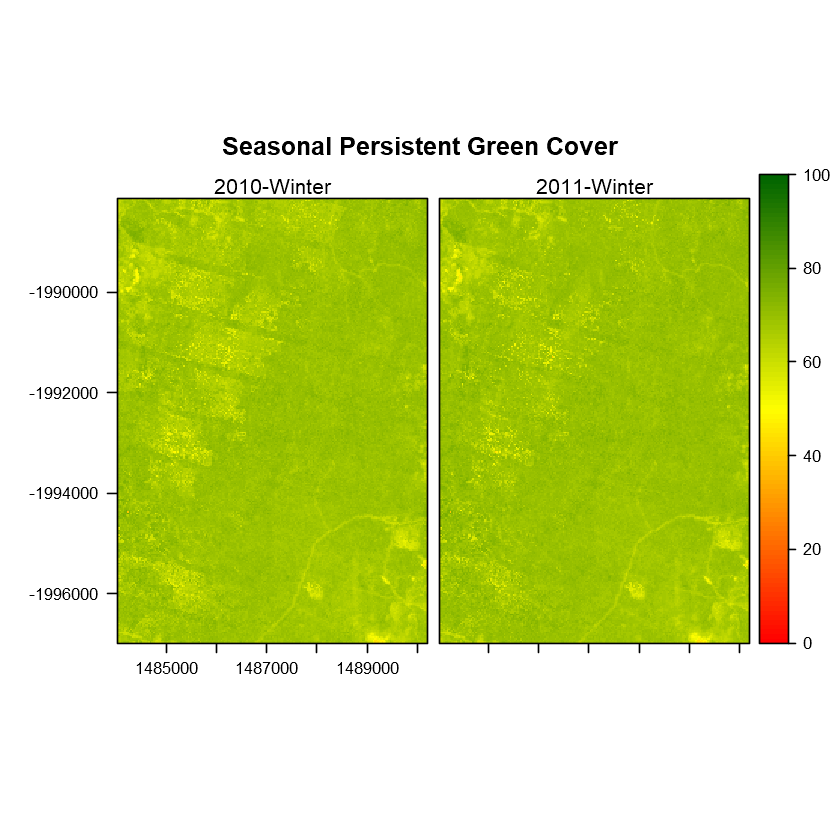

In [9]:
#------------------------------------------------------------------------------------------------------------------------
# Graphical Summary: Plot SPGC Values for both Seasons
#------------------------------------------------------------------------------------------------------------------------

# Create the color palette
# ------------------------ 
# Red: low SPGCs, Yellow: middle SPGCs; Green: high SPGCs (Darker Greens indicate Higher SPGCs)
SPGC.breaks = seq(0,100,by=1)
SPGC.cols = colorRampPalette(c("red", "yellow", "darkgreen"))(length(SPGC.breaks)-1)

# Create side by side plots
# -------------------------
levelplot(SPGC.StudyArea.2010q3_2011q3.rb, at=SPGC.breaks, col.regions=SPGC.cols, main="Seasonal Persistent Green Cover", names.attr=c("2010-Winter", "2011-Winter"))


### Compute Change in SPGC  between Winter 2010 and Winter 2011: Raster Calculations

In R raster calculations, involving 1 or more raster layers, can be conducted in 3 different ways: (1) using 'Raster Algegra', (2) using Higher Level Functions in the package raster, and (3) specialised functions from particular packages. A brief review of these methods is presented below. Further details and examples can be found in TERN's tutorial 'Using Raster Data in R'.

#### (1) 'Raster Algebra' (also known as 'Raster Maths')

Used for small rasters and simple calculations. 

Directly  combines rasters using:

* Operators (for more information on R Operators see this [link](https://www.datamentor.io/r-programming/operator/)):  
  * Arithmetic operators (+,'-,*,/,^,%%,%/%)
  * Relational operators (>, <, >=, <=, ==, !=)
  * Logical operators (!,&,&&,|,||)  
* Functions (algebraic (but 'abs'), summary, and logical functions need > 1 layer): 
  * Algebraic functions (e.g. abs, sum, prod)
  * Rounding functions (round, ceiling, floor, trunc)
  * Re-scaling functions (e.g. log, log10, sqrt, exp)
  * Trigonometric functions (e.g. sin, cos, tan, atan)
  * Summary functions (e.g. min, max, range)
  * Logical functions(any, all)  


#### (2) Raster Calculations using Higher Level Functions in the package `raster`

Directly adding, subtracting, etc. layers of big raster objects is not recommended. For big raster objects High Level Functions should be used instead. 

On the other hand, in many cases, what can be achieved with Higher Level Functions, can also be accomplished with a more intuitive 'raster-algebra' notation. For example, the log10 of the cells in a raster can be computed as log10(r), which is simpler than using `calc` with this function. However, `calc` should be faster when using large datasets and/or complex formulas. 

##### - For a Single Raster Object

The following `raster` package functions can be used: 

`calc`: Uses a single Raster\* object and a provided formula to calculate values for a new Raster\* object. 

The function type will depend of the input object type:

* For a uni-layer (RasterLayer) input, the function  is typically a function that can take a single vector as input and return a vector of values of the same length (e.g. sqrt). 
* For a multi-layer (RasterStack or RasterBrick) input, the function should operate on a vector of values, with one vector for each cell.

The object type returned depends on the input object type and function type:

* When input is a RasterLayer, it returns a RasterLayer.
* When input is a RasterStack or RasterBrick and the Function a Summary type Function (i.e. returns a single value), it returns a RasterLayer.
* When input is a RasterStack or RasterBrick and the Function returns more than one number (e.g. fun=quantile), it returns a RasterBrick.

The function can even be a statistical function, such as `lm`. See `calc` help for details.


`stackApply`: Computes summary type layers for subsets of a RasterStack or RasterBrick.

To do so it uses a summary function applied on subsets of layers of a RasterStack or RasterBrick object. These subsets are defined by vector indices. If the number of indices in the vector is smaller than the number of layers the indices are recycled.

The summary function must return a single value; thus, the number of layers in the output Raster\* equals then number of unique values in the indices vector. 
If the output raster contains a single layer it would be a RasterLayer object. If it contains multiple layers it would be a RasterBrick object.


`overlay`: It is typically used with multiple Raster\* objects, but it can also be used with a single `Raster*` object. However, it is often simpler to use `calc` (or "Raster Algebra") for single Raster\* objects. See next section for its application to multi-layered raster objects.


##### - For a Multiple  Raster Objects

Rasters in operations including multiple rasters must have the same Dimensions, Projection, Extent, and Resolution. 

The `raster` package function to perform calculations involving multiple Raster\* objects is `overlay`. It is more efficient that 'Raster Maths' when rasters are large and/or calculations complex and/or rasters stored in separate individual files. Do not confuse with the deprecated 'overlay' function in the 'sp' package. They are different.

Syntax:  output.ras = overlay(input1.ras, input2.ras, fun=FunctionCalcName)

The raster objects used as inputs can be single-layered or multi-layered rasters (with the same number of layers). Both case produce similar results. In the multi-layered rasters case the function is applied to each pair of layers.

#### (3) Raster Calculations using functions from other packages.
R raster packages other than `raster` contain functions that perform useful raster calculations. For example, the functions `normImage` and `spectralIndices` in the package `RStoolbox` can standardise the raster and compute multi-spectral indices (e.g. NDVI, EVI, SAVI,...) respectively.

#### Examples: Change in SPGC  between Winter 2010 and Winter 2011

Below we compute the change in SPGC between the winters of 2010 and 2011. First, we will compare the change in the raw (i.e. in percentages) values, and then in standardised (i.e. in standard deviations) values. Standardisation is a common method to compare change in the values of variables when the variables have very different standard deviations (e.g. when the variables have different units or were sampled from very different populations). For the comparison of standardised values to be adequate, the variables should be normally distributed (or close to it). Therefore, we first test for normality of the SPGC values (both graphically and statistically). We found that the SPGC values for both winters are left-skewed. We will still proceed to explore the change in stadardised SPGC values as a way to provide examples of raster calculations. However, the results obtained comparing standardised values should be interpreted with caution (and a pinch of salt). 


class       : RasterLayer 
dimensions  : 295, 206, 60770  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 1484025, 1490205, -1996985, -1988135  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : layer 
values      : -7.843137, 7.058824  (min, max)



	Shapiro-Wilk normality test

data:  sample(values(SPGC.StudyArea.2010q3.rl), 5000)
W = 0.89584, p-value < 2.2e-16


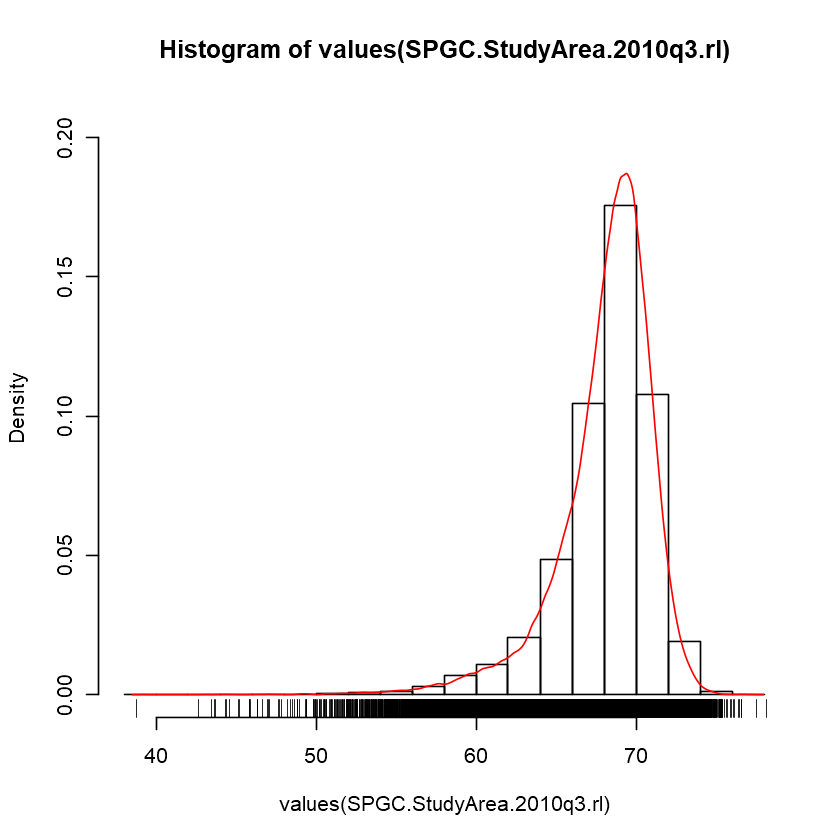


	Shapiro-Wilk normality test

data:  sample(values(SPGC.StudyArea.2011q3.rl), 5000)
W = 0.86518, p-value < 2.2e-16


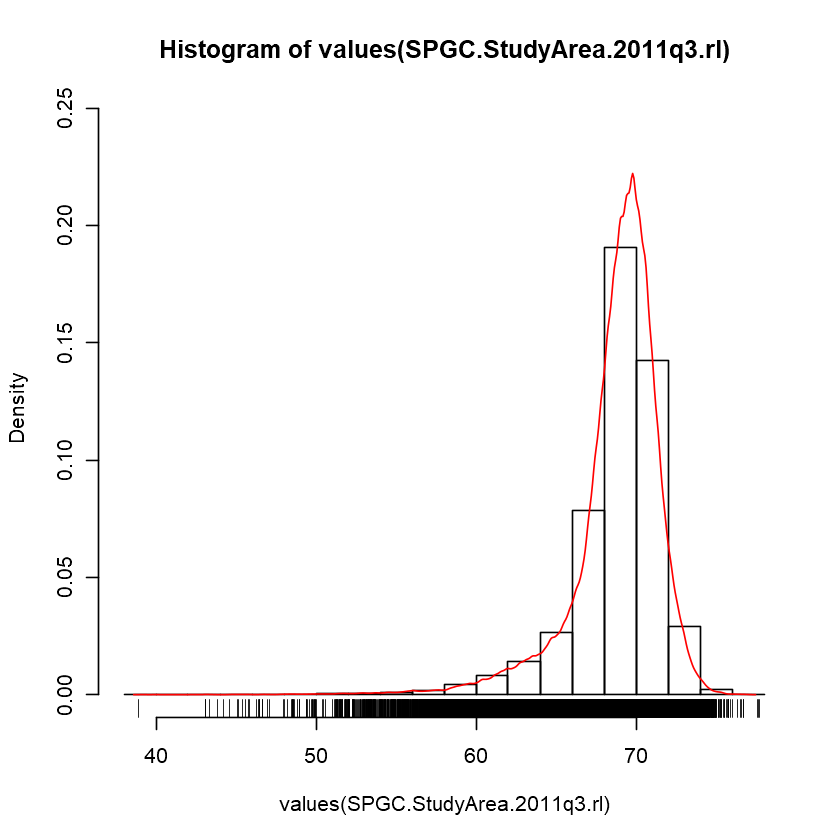

In [10]:
#========================================================================================================================
# Compute Change in SPGC  between Winter 2010 and Winter 2011: Raster Calculations
#========================================================================================================================


#------------------------------------------------------------------------------------------------------------------------
# Raw Change (in %)
#------------------------------------------------------------------------------------------------------------------------
# We use Raster Algegra to calculate Raw Change (i.e. change in %) in SPGC

SPGC.StudyArea.Diffq3.rl = SPGC.StudyArea.2011q3.rl - SPGC.StudyArea.2010q3.rl
SPGC.StudyArea.Diffq3.rl


#------------------------------------------------------------------------------------------------------------------------
# Standardised Difference (in SD)
#------------------------------------------------------------------------------------------------------------------------

#~~~~~~~~~~~~~~~~~~
# Assess Normality
#~~~~~~~~~~~~~~~~~~

# 2010 - Winter
# ............. 

## 'hist' & 'lines' methods for the package 'raster' doesn't work well they yield the histogram and density plot in 2 separate plots`
#hist(SPGC.StudyArea.2010q3.rl, probability=TRUE)
#lines(density(SPGC.StudyArea.2010q3.rl))

# Need to use the methods in the package 'graphics' (i.e. 'common' hist & lines methods) for the values in the rasters
hist.max=max(graphics::hist(values(SPGC.StudyArea.2010q3.rl), plot=FALSE)$d)
kd.max=max(stats::density(values(SPGC.StudyArea.2010q3.rl), na.rm=TRUE)$y)
ylim.max = max(c(hist.max, kd.max))*1.1
graphics::hist(values(SPGC.StudyArea.2010q3.rl), probability=TRUE, ylim=c(0,ylim.max))
lines(stats::density(values(SPGC.StudyArea.2010q3.rl), na.rm=TRUE), col="red")
rug(jitter(values(SPGC.StudyArea.2010q3.rl), amount = 0.9))

# Shapiro-Wilk test for normality sample size must be between 3 and 5000, so we 'sample' the values
shapiro.test(sample(values(SPGC.StudyArea.2010q3.rl),5000))

# 2011 - Winter
# .............

## 'hist' & 'lines' methods for the package 'raster' doesn't work well they yield the histogram and density plot in 2 separate plots`
#hist(SPGC.StudyArea.2011q3.rl, probability=TRUE)
#lines(density(SPGC.StudyArea.2011q3.rl))

# Need to use the methods in the package 'graphics' (i.e. 'common' hist & lines methods) for the values in the rasters
hist.max=max(graphics::hist(values(SPGC.StudyArea.2011q3.rl), plot=FALSE)$d)
kd.max=max(stats::density(values(SPGC.StudyArea.2011q3.rl), na.rm=TRUE)$y)
ylim.max = max(c(hist.max, kd.max))*1.1
graphics::hist(values(SPGC.StudyArea.2011q3.rl), probability=TRUE, ylim=c(0,ylim.max))
lines(stats::density(values(SPGC.StudyArea.2011q3.rl), na.rm=TRUE), col="red")
rug(jitter(values(SPGC.StudyArea.2010q3.rl), amount = 0.9))

 # Shapiro-Wilk test for normality sample size must be between 3 and 5000, so we 'sample' the values
shapiro.test(sample(values(SPGC.StudyArea.2011q3.rl),5000))


In [11]:
# Method 1: Compute using Raster Algebra
# --------------------------------------
SPGC.StudyArea.StdDiffq3.rl = ((SPGC.StudyArea.2011q3.rl - cellStats(SPGC.StudyArea.2011q3.rl,mean)) / cellStats(SPGC.StudyArea.2011q3.rl,sd)) - 
							   ((SPGC.StudyArea.2010q3.rl - cellStats(SPGC.StudyArea.2010q3.rl,mean)) / cellStats(SPGC.StudyArea.2010q3.rl,sd))
SPGC.StudyArea.StdDiffq3.rl


# Method 2: Compute using Higher Level Functions from the Package `raster`
# ------------------------------------------------------------------------

calc.DiffStdRaster.f = function(rla, r1b)
{
	diff.std.rl = ((r1b - cellStats(r1b, mean)) / cellStats(r1b, sd)) - ((rla - cellStats(rla, mean)) / cellStats(rla, sd))
	return(diff.std.rl)
} # calc.DiffStdRaster.f = function(rla, r1b)
SPGC.StudyArea.StdDiffq3.rl.m2 = calc.DiffStdRaster.f(SPGC.StudyArea.2010q3.rl, SPGC.StudyArea.2011q3.rl)
SPGC.StudyArea.StdDiffq3.rl.m2


# Method 3: Compute using function `normImage` in package 'RStoolbox'
# -------------------------------------------------------------------
SPGC.StudyArea.StdDiffq3.rl.m3 = normImage(SPGC.StudyArea.2011q3.rl) - normImage(SPGC.StudyArea.2010q3.rl)
SPGC.StudyArea.StdDiffq3.rl.m3


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Compare Rasters resulting from both Standarisation Methods & Remove Unwanted Objects
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
all.equal(SPGC.StudyArea.StdDiffq3.rl, SPGC.StudyArea.StdDiffq3.rl.m2)
all.equal(SPGC.StudyArea.StdDiffq3.rl, SPGC.StudyArea.StdDiffq3.rl.m3)

# Remove unnecessary (i.e. repeated) objects
#ls(pattern="SPGC.StudyArea.StdDiffq3")
rm(SPGC.StudyArea.StdDiffq3.rl.m2, SPGC.StudyArea.StdDiffq3.rl.m3)
#ls(pattern="SPGC.StudyArea.StdDiffq3")


class       : RasterLayer 
dimensions  : 295, 206, 60770  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 1484025, 1490205, -1996985, -1988135  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : layer 
values      : -3.245601, 2.273073  (min, max)


class       : RasterLayer 
dimensions  : 295, 206, 60770  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 1484025, 1490205, -1996985, -1988135  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : layer 
values      : -3.245601, 2.273073  (min, max)


class       : RasterLayer 
dimensions  : 295, 206, 60770  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 1484025, 1490205, -1996985, -1988135  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : layer 
values      : -3.245601, 2.273073  (min, max)


[1] TRUE

[1] TRUE

### Numerically Summarise Change in SPGC between Winter 2010 and Winter 2011

We summarise the change in SPGC across the difference raster using summary statistics (as we did for the SPGC values of each Year-Season, see above).


In [12]:
#=================================================================================
# Numerically Summarise Change in SPGC between Winter 2010 and Winter 2011
#=================================================================================

# Change in Raw (%) SPGC
# -----------------------
summary(SPGC.StudyArea.Diffq3.rl)
cellStats(SPGC.StudyArea.Diffq3.rl, mean)

# Change in Standardised (sd) SPGC
# --------------------------------
summary(SPGC.StudyArea.StdDiffq3.rl)
cellStats(SPGC.StudyArea.StdDiffq3.rl, mean)


,layer
Min.,-7.8431373
1st Qu.,0.0000000
Median,0.3921569
3rd Qu.,1.1764706
Max.,7.0588235
NA's,0.0000000


[1] 0.6949766

,layer
Min.,-3.24560132
1st Qu.,-0.21041677
Median,-0.06249532
3rd Qu.,0.14806370
Max.,2.27307320
NA's,0.00000000


[1] -3.198483e-15

### Visualise Change in SPGC between Winter 2010 and Winter 2011: Graph Raster Values

To further explore SPGC change between the winters of 2010 and 2011 we use several plots, including boxplots, scatter plots (with loess), density plots, and plots of the rasters with the differences between both years. For the former two we use functions `bwplot` and `splom` in the package `rasterVis`. We present two methods to create density plots: (1) using the function `densityplot` in the package `rasterVis`, and (2) the function `ggplot` in the packager `ggplot2`. The latter approach produce nicer graphs, but requires more elaborated coding. Code for both methods is provided, but in the workshop we will only cover the first method. To visualise the cell values of the difference rasters we use the function `levelplot` from the package `rasterVis` (as above, when exploring the SPGC values in both Seasons).

The functions `bwplot` and `splom` require a `RasterStack` or `RasterBrick` object. We already have a rasterBrick with raw (in %) values (i.e. for 2010-Winter and 2011-Winter). We need to create an analogous rasterBrick with standardised (i.e. in SDs) values. 

To create the the desnsity plot using the `ggplot` function, we first need to convert the raster cell values to a vector of values (i.e. a variable) using the `values` function in the `raster` package. Then we combine all variables into a data frame. Finally, convert the wide format data frame to long format (i.e. combining both year values in the same column with an additional column/variable containing the year-season), as this format is required in the arguments of the function `ggplot`.

Finally, we use the function `grid.arrange` from the package `gridExtra` to plot multiple grobs (i.e. grid graphical objects) on a page (i.e. in a single graph). 


class       : RasterBrick 
dimensions  : 295, 206, 60770, 2  (nrow, ncol, ncell, nlayers)
resolution  : 30, 30  (x, y)
extent      : 1484025, 1490205, -1996985, -1988135  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : SPGC.SA.Std2010q3, SPGC.SA.Std2011q3 
min values  :         -9.645614,        -10.521245 
max values  :          3.048260,          2.860489 


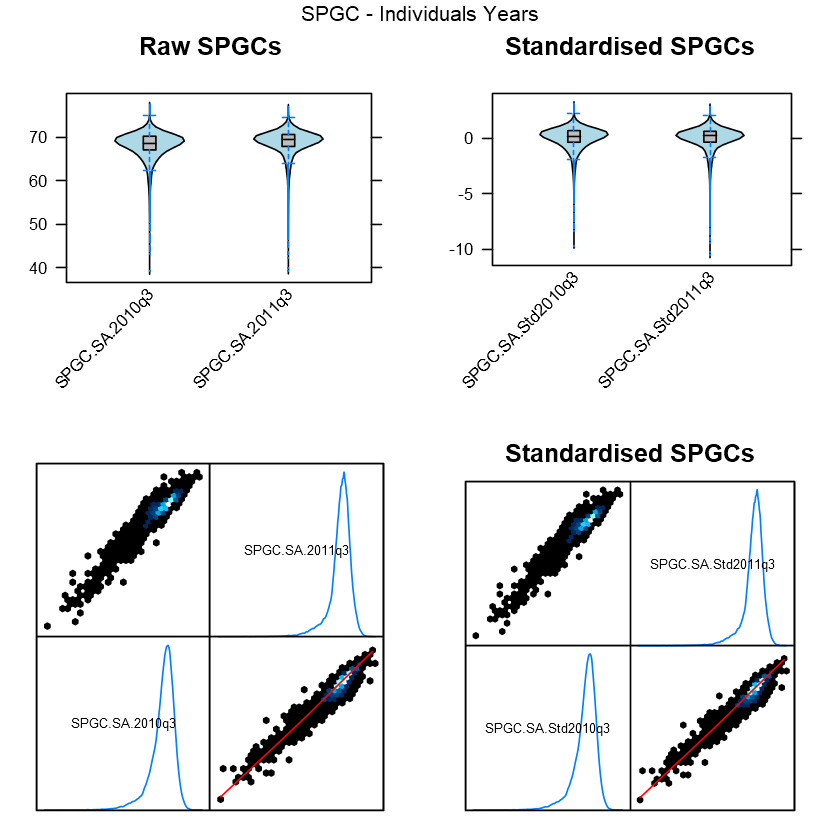

No id variables; using all as measure variables
No id variables; using all as measure variables


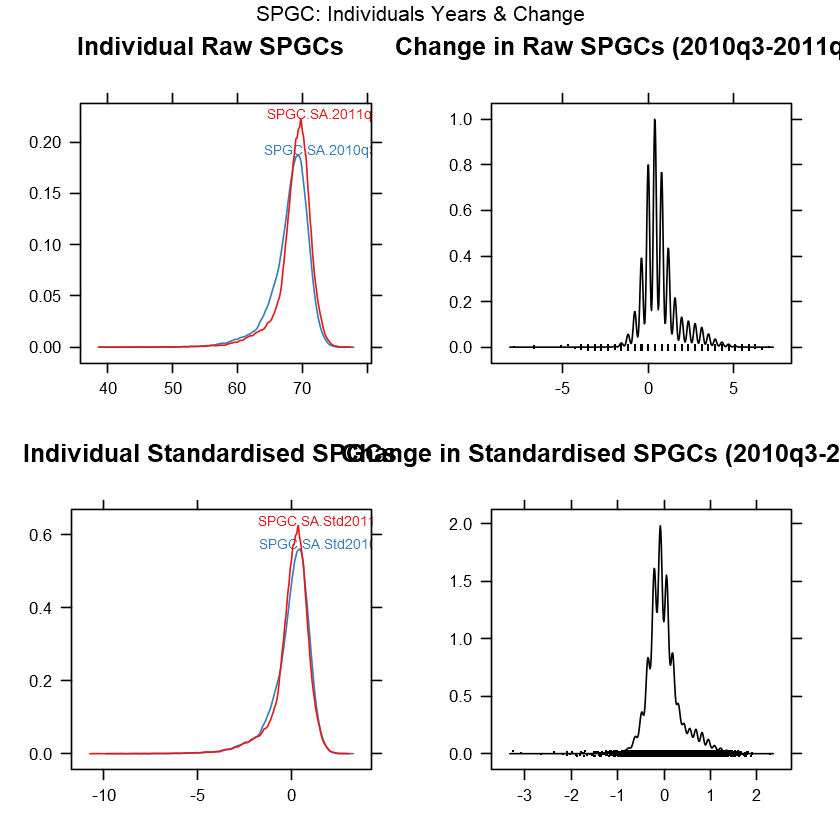

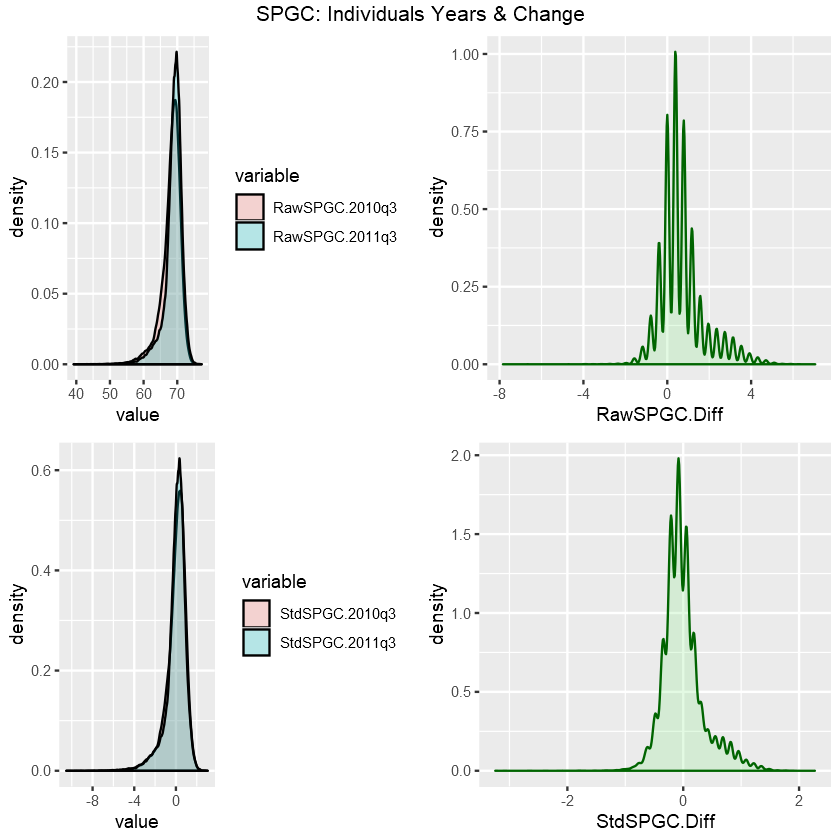

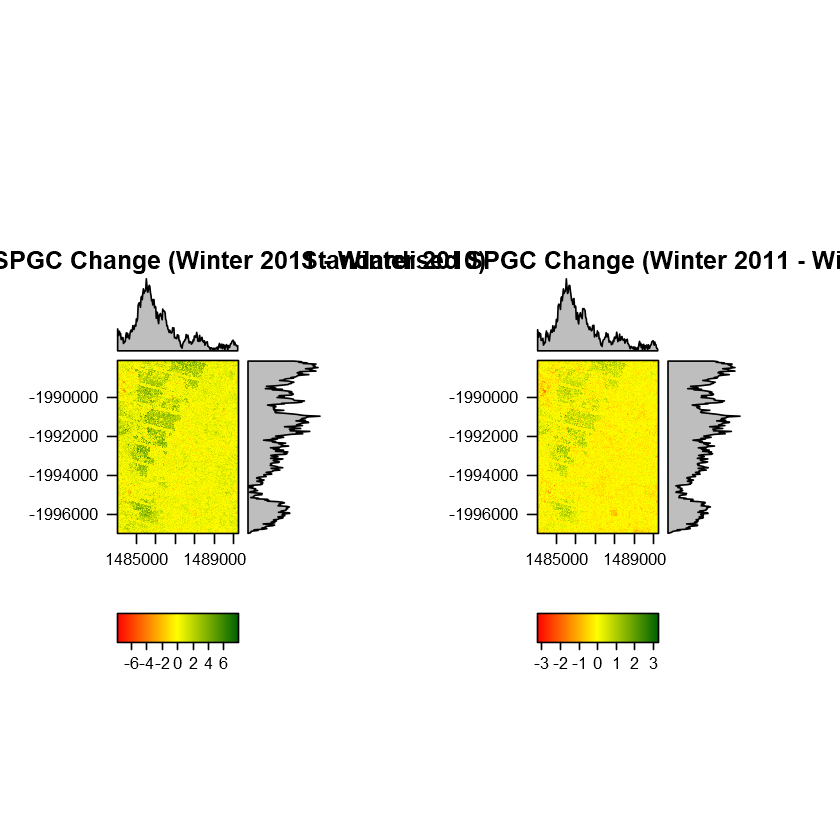

In [13]:
#========================================================================================================================
# Visualise Change in SPGC between Winter 2010 and Winter 2011: Graph Raster Values
#========================================================================================================================
# We already have a rasterBrick with individuals raw (in %) values (i.e. for 2010-Winter and 2011-Winter).
# We need to create an analogous rasterBrick with standarised (i.e. in SDs) values.


# Create RasterBrick object with Standardised SPGC
# ------------------------------------------------
SPGC.StudyArea.Std2010q3_2011q3.rb = brick(normImage(SPGC.StudyArea.2010q3.rl), normImage(SPGC.StudyArea.2011q3.rl))
names(SPGC.StudyArea.Std2010q3_2011q3.rb) = c("SPGC.SA.Std2010q3", "SPGC.SA.Std2011q3")		  
SPGC.StudyArea.Std2010q3_2011q3.rb


#------------------------------------------------------------------------------------------------------------------------
# Boxplots
#------------------------------------------------------------------------------------------------------------------------

# Change in 'Raw' SPGC
# --------------------
RawSPGC.IndvYrs.bwplot = bwplot(SPGC.StudyArea.2010q3_2011q3.rb, main="Raw SPGCs")

# Change in Standardised SPGC
# ---------------------------
StdSPGC.IndvYrs.bwplot = bwplot(SPGC.StudyArea.Std2010q3_2011q3.rb, main="Standardised SPGCs")


#------------------------------------------------------------------------------------------------------------------------
# Scatter plots with loess
#------------------------------------------------------------------------------------------------------------------------

# Change in 'Raw' SPGC
# --------------------
RawSPGC.IndvYrs.splot = splom(SPGC.StudyArea.2010q3_2011q3.rb, plot.loess=TRUE, xlab='')

# Change in Standardised  SPGC
# ----------------------------
StdSPGC.IndvYrs.splot = splom(SPGC.StudyArea.Std2010q3_2011q3.rb, main="Standardised SPGCs", plot.loess=TRUE, xlab='')


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Combine the 4 Plots in a single Graph
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
grid.arrange( RawSPGC.IndvYrs.bwplot, StdSPGC.IndvYrs.bwplot, 
              RawSPGC.IndvYrs.splot, StdSPGC.IndvYrs.splot,
              nrow=2, top="SPGC - Individuals Years" )

			  
			  		  
#------------------------------------------------------------------------------------------------------------------------   
# Density Plots
#------------------------------------------------------------------------------------------------------------------------

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Method 1: Using 'densityplot' from the package 'rasterVis`
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Change in 'Raw' SPGC
# --------------------
RawSPGC.IndvYrs.dp = densityplot(SPGC.StudyArea.2010q3_2011q3.rb, main="Individual Raw SPGCs")
RawSPGC.Diff.dp = densityplot(SPGC.StudyArea.Diffq3.rl, main="Change in Raw SPGCs (2010q3-2011q3)")

# Change in Standardised SPGC
# ---------------------------
StdSPGC.IndvYrs.dp = densityplot(SPGC.StudyArea.Std2010q3_2011q3.rb, main="Individual Standardised SPGCs")
StdSPGC.Diff.dp = densityplot(SPGC.StudyArea.StdDiffq3.rl, main="Change in Standardised SPGCs (2010q3-2011q3)")

# Combine 4 Plots in a Graph
# ~~~~~~~~~~~~~~~~~~~~~~~~~~
grid.arrange( RawSPGC.IndvYrs.dp, RawSPGC.Diff.dp, StdSPGC.IndvYrs.dp, StdSPGC.Diff.dp,
              nrow=2, top="SPGC: Individuals Years & Change" )
			  
	  
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Method 2: Using 'ggplot' from the package 'ggplot2`
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Create a DataFrame with the required values 
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Create a DataFrame with the required values to pass to function 'ggplot' in the package 'ggplot2' 
# Required values: SPGCs for 2010q3, 2011q3, and their difference in both scales: Raw and Standardised .
RawSPGC.2010q3 = values(SPGC.StudyArea.2010q3.rl)
RawSPGC.2011q3 = values(SPGC.StudyArea.2011q3.rl)
RawSPGC.Diff = values(SPGC.StudyArea.Diffq3.rl)
StdSPGC.2010q3 = values(normImage(SPGC.StudyArea.2010q3.rl))
StdSPGC.2011q3 = values(normImage(SPGC.StudyArea.2011q3.rl))
StdSPGC.Diff = values(SPGC.StudyArea.StdDiffq3.rl)
SPGCs.df = data.frame( RawSPGC.2010q3, RawSPGC.2011q3, RawSPGC.Diff, 
                       StdSPGC.2010q3, StdSPGC.2011q3, StdSPGC.Diff )
#summary(SPGCs.df)
                               

# Change in 'Raw' SPGC
# --------------------

# Density plot of Raw SPGC values for Individual Years 
# ....................................................
# Subset Dataset and convert wide format to long format
RawSPGC.IndvYrs.dflf = melt(SPGCs.df[c("RawSPGC.2010q3","RawSPGC.2011q3")])
RawSPGC.IndvYrs.dp2 = ggplot(RawSPGC.IndvYrs.dflf, aes(x=value, fill=variable)) +
                      geom_density(alpha=0.25)
                   
# Density plot of the change in Raw SPGC values
# ....................................................
RawSPGC.Diff.dp2 = ggplot(SPGCs.df, aes(x=RawSPGC.Diff)) + 
                   geom_density(alpha=0.25,color="darkgreen", fill="lightgreen")
                   

# Change in Standardised SPGC
# ---------------------------

# Density plot of Raw SPGC values for Individual Years 
# ....................................................
# Subset Dataset and convert wide format to long format
StdSPGC.IndvYrs.dflf = melt(SPGCs.df[c("StdSPGC.2010q3","StdSPGC.2011q3")])
StdSPGC.IndvYrs.dp2 = ggplot(StdSPGC.IndvYrs.dflf, aes(x=value, fill=variable)) +
                       geom_density(alpha=0.25)
                   
# Density plot of the change in Raw SPGC values
# ....................................................
StdSPGC.Diff.dp2 = ggplot(SPGCs.df, aes(x=StdSPGC.Diff)) + 
                    geom_density(alpha=0.25,color="darkgreen", fill="lightgreen")

                    
# Combine the 4 Plots in a single Graph
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
grid.arrange( RawSPGC.IndvYrs.dp2, RawSPGC.Diff.dp2, StdSPGC.IndvYrs.dp2, StdSPGC.Diff.dp2,
              nrow=2, top="SPGC: Individuals Years & Change" )  
			  
			  

#------------------------------------------------------------------------------------------------------------------------
# Rasters with Differences between both years (Raw & Standardised)
#------------------------------------------------------------------------------------------------------------------------
# They have very differnt scales (Raw SPGC and Standardised SPGC values)


# Change in Raw SPGC 
# -------------------
#SPGC.StudyArea.Diffq3.rl

# Create the color palette
# ........................
abs.max = max(abs(values(SPGC.StudyArea.Diffq3.rl)), na.rm=TRUE)
# Red: low SPGCs, Yellow: middle SPGCs; Green: high SPGCs (Darker Greens indicate Higher SPGCs)
RawSPGC.Diff.breaks = seq(-abs.max,abs.max, by=0.01)
RawSPGC.Diff.cols = colorRampPalette(c("red", "yellow", "darkgreen"))(length(RawSPGC.Diff.breaks)-1)

# Create Raster Plots with Density Plots
# ......................................
StudyArea.RawSPGCDiff.p = levelplot( SPGC.StudyArea.Diffq3.rl, at=RawSPGC.Diff.breaks, 
                                     col.regions=RawSPGC.Diff.cols, main="Raw SPGC Change (Winter 2011 - Winter 2010)" )                               
                                   

# Change in Standardised SPGC
# ---------------------------
#SPGC.StudyArea.StdDiffq3.rl

# Create the color palette
# ........................
abs.max = max(abs(values(SPGC.StudyArea.StdDiffq3.rl)), na.rm=TRUE)
# Red: low SPGCs, Yellow: middle SPGCs; Green: high SPGCs (Darker Greens indicate Higher SPGCs)
StdSPGC.Diff.breaks = seq(-abs.max,abs.max, by=0.01)
StdSPGC.Diff.cols = colorRampPalette(c("red", "yellow", "darkgreen"))(length(StdSPGC.Diff.breaks)-1)
                            
# Create Raster Plots with Density Plots
# ......................................
StudyArea.StdSPGCDiff.p = levelplot(SPGC.StudyArea.StdDiffq3.rl, at=StdSPGC.Diff.breaks, 
                                     col.regions=StdSPGC.Diff.cols, main="Standardised SPGC Change (Winter 2011 - Winter 2010)")
                            

# Plot Raster Plots
# ~~~~~~~~~~~~~~~~~
# `grid.arrange` provides multiple plots per page. They look good on screen, 
# but might be too small in the Workshop/Tutorial report. 

# Plot Raw & Standardised Change in SPGC from the Winter of 2010 to the Winter of 2011
grid.arrange(StudyArea.RawSPGCDiff.p, StudyArea.StdSPGCDiff.p, nrow=1)

# Create individual plots of SPGC rasters for both years (previously both years graphed in a single plot)
SA.SPGC.2010q3.p = levelplot(SPGC.StudyArea.2010q3.rl, at=SPGC.breaks, col.regions=SPGC.cols, main="Seasonal Persistent Green Cover (2010-Winter)")
SA.SPGC.2011q3.p = levelplot(SPGC.StudyArea.2011q3.rl, at=SPGC.breaks, col.regions=SPGC.cols, main="Seasonal Persistent Green Cover (2011-Winter)")
## Plot Raw Values (top row) + Raw & Standardised Change (bottom row)
#grid.arrange(SA.SPGC.2010q3.p, SA.SPGC.2011q3.p, StudyArea.RawSPGCDiff.p, StudyArea.StdSPGCDiff.p, nrow=2)


## Seasonal Persistent Green Cover (SPGC)


### Download Data


In [14]:
#========================================================================================================================
# Download Data
#========================================================================================================================

SGGC.URL = "http://qld.auscover.org.au/public/data/landsat/seasonal_fractional_cover/ground_cover/aus/"
SGGC.TS.fn = "lztmre_aus_s198912201811_dixa2_green.vrt"

# Download the data files (if it doesn't work try method='wget' or functions in Library 'RCurl')
download.file(url=paste(SGGC.URL, SGGC.TS.fn, sep="/"), destfile='SGGC_TS.vrt', method='auto')
list.files()


[1] "JNb_YasiEffectsonGCatMB_Tutorial.html" 
 [2] "JNb_YasiEffectsonGCatMB_Tutorial.ipynb"
 [3] "JNb_YasiEffectsonGCatMB_Tutorial.pdf"  
 [4] "README.md"                             
 [5] "SGC_StudyArea_Res.grd"                 
 [6] "SGC_StudyArea_Res.gri"                 
 [7] "SGC_StudyArea_Res.hdr"                 
 [8] "SGC_StudyArea_Res.nc"                  
 [9] "SGC_StudyArea_Res.stx"                 
[10] "SGGC_TS.vrt"                           
[11] "SPGC_2010q3.vrt"                       
[12] "SPGC_2011q3.vrt"                       
[13] "SPGC_TS.vrt"                           
[14] "YasiEffectsonGCatMB._Tutorial.html"    
[15] "YasiEffectsonGCatMB._Tutorial.Rmd"     
[16] "YasiEffectsonGCatMB._Tutorial_files"   
[17] "YasiEffectsonGCatMB_Tutorial.pdf"      
[18] "YasiEffectsonGCatMB_Tutorial.r"

### Load Data


In [15]:
#========================================================================================================================
# Load Data
#========================================================================================================================

#SGGC.path = "C:/Users/uqbblanc/Documents/TERN/04b-DSDP_GitHub/Prep/Landscapes_AusCover-RemoteSensing/Data_RS/Seasonal_GC"
SGGC.path = getwd()


# Load a Single Band Raster from a file containing a Multiple-Bands Raster
# ------------------------------------------------------------------------
# The TS starts on 1999q1 (in reality, it contains data from Dec 1989 to Feb 1990)
# We want 2010q3 and 2011q3, which are 82((2010-1990)*4+2) and 86 (2011-1990)*4+2) bands away from the initial band

SGGC.2010q3.rl = raster(paste(SGGC.path, 'SGGC_TS.vrt', sep="/"), band = (1 + (2010-1990)*4 + 2))
SGGC.2010q3.rl

SGGC.2011q3.rl = raster(paste(SGGC.path, 'SGGC_TS.vrt', sep="/"), band = (1 + (2011-1990)*4 + 2))
SGGC.2011q3.rl


# Load a Multiple-Bands Raster from a file containing a Multiple-Bands Raster
# ---------------------------------------------------------------------------
# Load the whole TS of rasters.
# We use the functions 'stack' or 'brick' depending on the desired raster object.
SGGC.TS.rb = brick(paste(SGGC.path, 'SGGC_TS.vrt', sep="/"))
SGGC.TS.rb

# Extract the required Single Layers (i.e. Year-Season) from the TS 
SGGC.2010q3.rlb = raster(SGGC.TS.rb, layer = (1 + (2010-1990)*4 + 2))
SGGC.2010q3.rlb
SGGC.2011q3.rlb = raster(SGGC.TS.rb, layer = (1 + (2011-1990)*4 + 2))
SGGC.2011q3.rlb


class       : RasterLayer 
band        : 83  (of  119  bands)
dimensions  : 135159, 141481, 19122430479  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : -1944645, 2299785, -4910195, -855425  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : C:/Users/uqbblanc/Documents/TERN/04b-DSDP_GitHub/Prep/Landscapes_AusCover-RemoteSensing/YasiEffectsonGCatMB/YasiEffectsonGCatMB_Tutorial/SGGC_TS.vrt 
names       : SGGC_TS 
values      : 0, 255  (min, max)


class       : RasterLayer 
band        : 87  (of  119  bands)
dimensions  : 135159, 141481, 19122430479  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : -1944645, 2299785, -4910195, -855425  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : C:/Users/uqbblanc/Documents/TERN/04b-DSDP_GitHub/Prep/Landscapes_AusCover-RemoteSensing/YasiEffectsonGCatMB/YasiEffectsonGCatMB_Tutorial/SGGC_TS.vrt 
names       : SGGC_TS 
values      : 0, 255  (min, max)


class       : RasterBrick 
dimensions  : 135159, 141481, 19122430479, 119  (nrow, ncol, ncell, nlayers)
resolution  : 30, 30  (x, y)
extent      : -1944645, 2299785, -4910195, -855425  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : C:/Users/uqbblanc/Documents/TERN/04b-DSDP_GitHub/Prep/Landscapes_AusCover-RemoteSensing/YasiEffectsonGCatMB/YasiEffectsonGCatMB_Tutorial/SGGC_TS.vrt 
names       : SGGC_TS.1, SGGC_TS.2, SGGC_TS.3, SGGC_TS.4, SGGC_TS.5, SGGC_TS.6, SGGC_TS.7, SGGC_TS.8, SGGC_TS.9, SGGC_TS.10, SGGC_TS.11, SGGC_TS.12, SGGC_TS.13, SGGC_TS.14, SGGC_TS.15, ... 
min values  :         0,         0,         0,         0,         0,         0,         0,         0,         0,          0,          0,          0,          0,          0,          0, ... 
max values  :       255,       255,       255,       255,       255,       255,       255,       255,       255,        255,        25

class       : RasterLayer 
band        : 83  (of  119  bands)
dimensions  : 135159, 141481, 19122430479  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : -1944645, 2299785, -4910195, -855425  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : C:/Users/uqbblanc/Documents/TERN/04b-DSDP_GitHub/Prep/Landscapes_AusCover-RemoteSensing/YasiEffectsonGCatMB/YasiEffectsonGCatMB_Tutorial/SGGC_TS.vrt 
names       : SGGC_TS.83 
values      : 0, 255  (min, max)


class       : RasterLayer 
band        : 87  (of  119  bands)
dimensions  : 135159, 141481, 19122430479  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : -1944645, 2299785, -4910195, -855425  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : C:/Users/uqbblanc/Documents/TERN/04b-DSDP_GitHub/Prep/Landscapes_AusCover-RemoteSensing/YasiEffectsonGCatMB/YasiEffectsonGCatMB_Tutorial/SGGC_TS.vrt 
names       : SGGC_TS.87 
values      : 0, 255  (min, max)


### Subset Rasters to Study Area


In [16]:
#========================================================================================================================
# Subset Rasters to Study Area
#========================================================================================================================

#------------------------------------------------------------------------------------------------------------------------
# Create Cookie Cutter for the Study Area
#------------------------------------------------------------------------------------------------------------------------
# Already done above for the Seasosnal Persistent Green Cover (SPGC)
# However, we do it again to double check that SGGC rasters also have a EPSG:3577 CRS

# Change Study Area spatial polygon CRS to the Australian-specific CRS used for raster.
# EPSG:3577 = 'GDA94'/'Australian Albers' - General Spatial Reference (https://spatialreference.org/ref/epsg/3577/)
# (Area: Australia (all states), Scope: Australia-wide geoscience and statistical mapping).

# Find Raster CRS
SGGC.2010q3.rl
crs(SGGC.2010q3.rl)
# Double check that this is the EPSG:3577 CRS (= to the raster's CRS)
CRS("+init=epsg:3577")

# Transform the Spatial Polygon CRS (from EPSG:4326 to EPSG:3577)
StudyArea.SP.reprj = spTransform(StudyArea.SP, CRS("+init=epsg:3577"))

# Study Area Reprojected Extent
StudyArea.extent.reprj = extent(StudyArea.SP.reprj) 
StudyArea.extent.reprj

#------------------------------------------------------------------------------------------------------------------------
# Subset (i.e. crop) raster layer to area of interest
#------------------------------------------------------------------------------------------------------------------------
# Subset both Year-Season rasters
SGGC.StudyArea.2010q3.rl = crop(SGGC.2010q3.rl, StudyArea.extent.reprj)
SGGC.StudyArea.2010q3.rl
SGGC.StudyArea.2011q3.rl = crop(SGGC.2011q3.rl, StudyArea.extent.reprj)
SGGC.StudyArea.2011q3.rl


class       : RasterLayer 
band        : 83  (of  119  bands)
dimensions  : 135159, 141481, 19122430479  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : -1944645, 2299785, -4910195, -855425  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : C:/Users/uqbblanc/Documents/TERN/04b-DSDP_GitHub/Prep/Landscapes_AusCover-RemoteSensing/YasiEffectsonGCatMB/YasiEffectsonGCatMB_Tutorial/SGGC_TS.vrt 
names       : SGGC_TS 
values      : 0, 255  (min, max)


CRS arguments:
 +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0
+ellps=GRS80 +units=m +no_defs 

CRS arguments:
 +init=epsg:3577 +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132
+x_0=0 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs 

class       : Extent 
xmin        : 1484019 
xmax        : 1490198 
ymin        : -1996975 
ymax        : -1988144 

class       : RasterLayer 
dimensions  : 295, 206, 60770  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 1484025, 1490205, -1996985, -1988135  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : SGGC_TS 
values      : 100, 201  (min, max)


class       : RasterLayer 
dimensions  : 295, 206, 60770  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 1484025, 1490205, -1996985, -1988135  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : SGGC_TS 
values      : 95, 198  (min, max)


### Re-scale raster cell values


In [17]:
#========================================================================================================================
# Re-scale raster cell values
#========================================================================================================================
# The cell values are in scale 0-255, so we re-scale them a 0-100 scale to represent the Green Cover Fraction in Percentage.
# Generalized version ((X - Xmin) * 100) / (Xmax - Xmin)
SGGC.StudyArea.2010q3.rl = SGGC.StudyArea.2010q3.rl * 100 / 255
SGGC.StudyArea.2010q3.rl
SGGC.StudyArea.2011q3.rl = SGGC.StudyArea.2011q3.rl * 100 / 255
SGGC.StudyArea.2011q3.rl


class       : RasterLayer 
dimensions  : 295, 206, 60770  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 1484025, 1490205, -1996985, -1988135  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : SGGC_TS 
values      : 39.21569, 78.82353  (min, max)


class       : RasterLayer 
dimensions  : 295, 206, 60770  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 1484025, 1490205, -1996985, -1988135  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : SGGC_TS 
values      : 37.2549, 77.64706  (min, max)


### Combine both Single-Layer Rasters (RasterLayer objects) into a Multi-Layer Rasters (RasterBrick object)


In [18]:
#========================================================================================================================
# Combine both Single-Layer Rasters (Rasterlayer objects) into a Multi-Layer Rasters (RasterBrick object)
#========================================================================================================================
SGGC.StudyArea.2010q3_2011q3.rb = brick(SGGC.StudyArea.2010q3.rl, SGGC.StudyArea.2011q3.rl)
names(SGGC.StudyArea.2010q3_2011q3.rb) = c("SGGC.SA.2010q3", "SGGC.SA.2011q3")		  
SGGC.StudyArea.2010q3_2011q3.rb


class       : RasterBrick 
dimensions  : 295, 206, 60770, 2  (nrow, ncol, ncell, nlayers)
resolution  : 30, 30  (x, y)
extent      : 1484025, 1490205, -1996985, -1988135  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : SGGC.SA.2010q3, SGGC.SA.2011q3 
min values  :       39.21569,       37.25490 
max values  :       78.82353,       77.64706 


### Explore SGGC values in both Seasons (Winter 2010 vs Winter 2011)

Now we procede to explore the rasters SGGC values. First we explore this values Numerically (i.e. Summary Statistics), and then Graphically (i.e. ploting the rasters).

#### Numerical Summary of SGGC Values for both Seasons


In [19]:
#========================================================================================================================
# Explore SGGC values in both Seasons (Winter 2011 vs Winter 2010)
#========================================================================================================================

#------------------------------------------------------------------------------------------------------------------------
# Numerical Summary of SGGC Values for both Seasons
#------------------------------------------------------------------------------------------------------------------------

# Summary Statistics (Min, 1st Quartile, Median, 3rd Quartile, Max, and Number of NA's)
summary(SGGC.StudyArea.2010q3_2011q3.rb)
# Mean
cellStats(SGGC.StudyArea.2010q3_2011q3.rb, mean)


,SGGC_TS.1,SGGC_TS.2
Min.,39.21569,37.25490
1st Qu.,65.78431,59.21569
Median,69.60784,66.27451
3rd Qu.,72.54902,69.41176
Max.,78.82353,77.64706
NA's,60442.00000,59655.00000


SGGC.SA.2010q3 SGGC.SA.2011q3 
      68.68125       62.88754

#### Graphical Summary: Plot SPGC Values for both Seasons


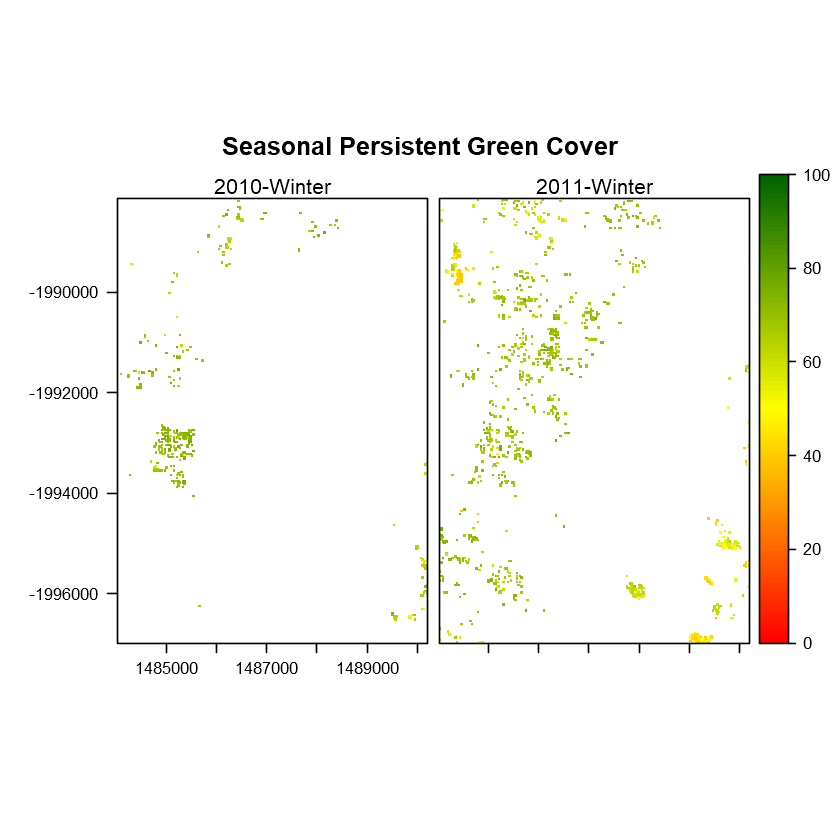

In [20]:
#------------------------------------------------------------------------------------------------------------------------
# Plot SGGC Values for both Seasons
#------------------------------------------------------------------------------------------------------------------------

# Create the color palette
# ------------------------ 
# Red: low SGGCs, Yellow: middle SGGCs; Green: high SGGCs (Darker Greens indicate Higher SGGCs)
SGGC.breaks = seq(0,100,by=1)
SGGC.cols = colorRampPalette(c("red", "yellow", "darkgreen"))(length(SGGC.breaks)-1)

# Create side by side plots
# -------------------------
levelplot(SGGC.StudyArea.2010q3_2011q3.rb, at=SGGC.breaks, col.regions=SGGC.cols, main="Seasonal Persistent Green Cover", names.attr=c("2010-Winter", "2011-Winter"))


### Compute Change in SGGC  between Winter 2010 and Winter 2011: Raster Calculations


class       : RasterLayer 
dimensions  : 295, 206, 60770  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 1484025, 1490205, -1996985, -1988135  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : layer 
values      : -25.4902, 10.58824  (min, max)



	Shapiro-Wilk normality test

data:  sample(values(SGGC.StudyArea.2010q3.rl), 5000)
W = 0.96844, p-value = 0.5394


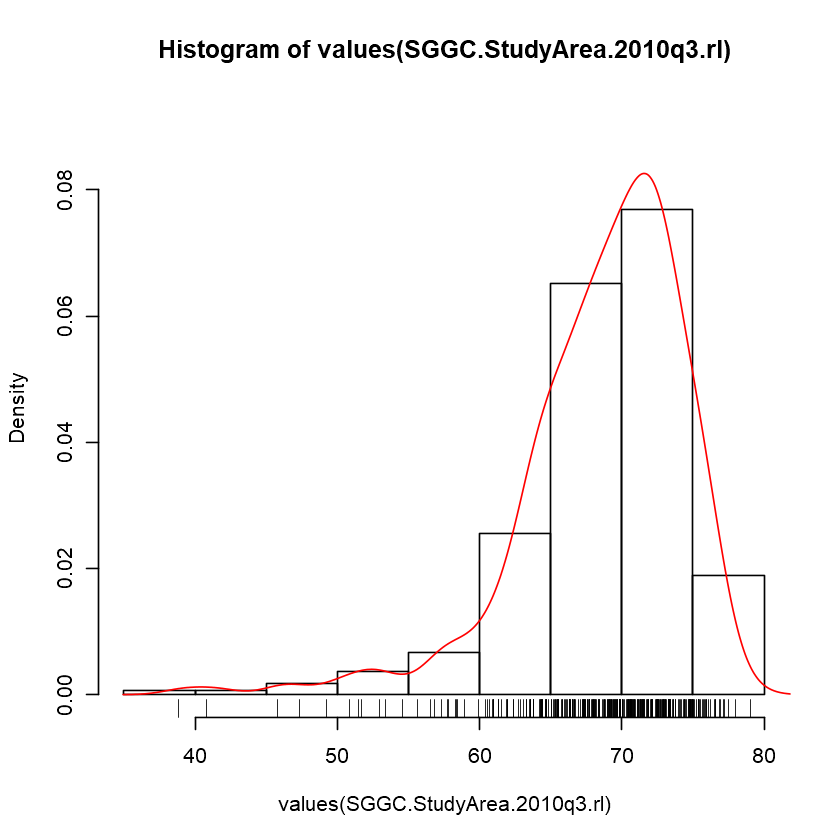


	Shapiro-Wilk normality test

data:  sample(values(SGGC.StudyArea.2011q3.rl), 5000)
W = 0.85222, p-value = 1.28e-07


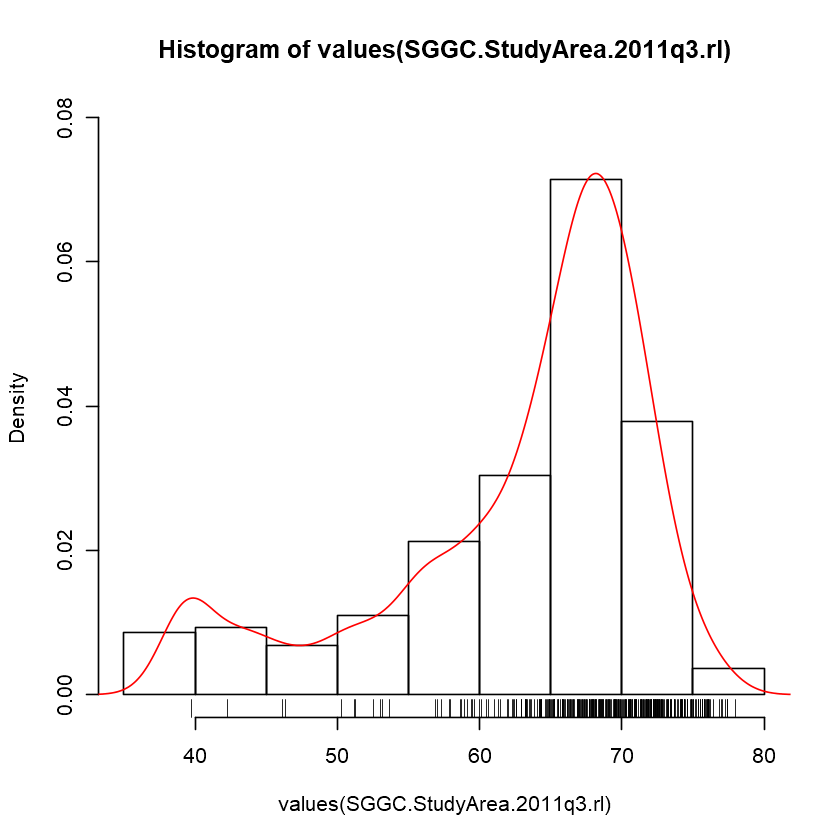

In [21]:
#========================================================================================================================
# Compute Change in SGGC between Winter 2010 and Winter 2011: Raster Calculations 
#========================================================================================================================
# We use Raster Algegra (and Functions) calculate Change in SGGC


#------------------------------------------------------------------------------------------------------------------------
# Raw Change (in %)
#------------------------------------------------------------------------------------------------------------------------
SGGC.StudyArea.Diffq3.rl = SGGC.StudyArea.2011q3.rl - SGGC.StudyArea.2010q3.rl
SGGC.StudyArea.Diffq3.rl


#------------------------------------------------------------------------------------------------------------------------
# Standardised Difference (in SD)
#------------------------------------------------------------------------------------------------------------------------

#~~~~~~~~~~~~~~~~~~
# Assess Normality
#~~~~~~~~~~~~~~~~~~

# 2010 - Winter
# ............. 

## 'hist' & 'lines' methods for the package 'raster' doesn't work well they yield the histogram and density plot in 2 separate plots`
#hist(SGGC.StudyArea.2010q3.rl, probability=TRUE)
#lines(density(SGGC.StudyArea.2010q3.rl))

# Need to use the methods in the package 'graphics' (i.e. 'common' hist & lines methods) for the values in the rasters
hist.max=max(graphics::hist(values(SGGC.StudyArea.2010q3.rl), plot=FALSE)$d)
kd.max=max(stats::density(values(SGGC.StudyArea.2010q3.rl), na.rm=TRUE)$y)
ylim.max = max(c(hist.max, kd.max))*1.1
graphics::hist(values(SGGC.StudyArea.2010q3.rl), probability=TRUE, ylim=c(0,ylim.max))
lines(stats::density(values(SGGC.StudyArea.2010q3.rl), na.rm=TRUE), col="red")
rug(jitter(values(SGGC.StudyArea.2010q3.rl), amount = 0.9))

# Shapiro-Wilk test for normality sample size must be between 3 and 5000, so we 'sample' the values
shapiro.test(sample(values(SGGC.StudyArea.2010q3.rl),5000))

# 2011 - Winter
# .............

## 'hist' & 'lines' methods for the package 'raster' doesn't work well they yield the histogram and density plot in 2 separate plots`
#hist(SGGC.StudyArea.2011q3.rl, probability=TRUE)
#lines(density(SGGC.StudyArea.2011q3.rl))

# Need to use the methods in the package 'graphics' (i.e. 'common' hist & lines methods) for the values in the rasters
hist.max=max(graphics::hist(values(SGGC.StudyArea.2011q3.rl), plot=FALSE)$d)
kd.max=max(stats::density(values(SGGC.StudyArea.2011q3.rl), na.rm=TRUE)$y)
ylim.max = max(c(hist.max, kd.max))*1.1
graphics::hist(values(SGGC.StudyArea.2011q3.rl), probability=TRUE, ylim=c(0,ylim.max))
lines(stats::density(values(SGGC.StudyArea.2011q3.rl), na.rm=TRUE), col="red")
rug(jitter(values(SGGC.StudyArea.2010q3.rl), amount = 0.9))

 # Shapiro-Wilk test for normality sample size must be between 3 and 5000, so we 'sample' the values
shapiro.test(sample(values(SGGC.StudyArea.2011q3.rl),5000))


In [22]:
# Method 1: Compute using Raster Algebra
# --------------------------------------
SGGC.StudyArea.StdDiffq3.rl = ((SGGC.StudyArea.2011q3.rl - cellStats(SGGC.StudyArea.2011q3.rl,mean)) / cellStats(SGGC.StudyArea.2011q3.rl,sd)) - 
							   ((SGGC.StudyArea.2010q3.rl - cellStats(SGGC.StudyArea.2010q3.rl,mean)) / cellStats(SGGC.StudyArea.2010q3.rl,sd))
SGGC.StudyArea.StdDiffq3.rl


# Method 2: Compute using Higher Level Functions from the Package `raster`
# ------------------------------------------------------------------------

calc.DiffStdRaster.f = function(rla, r1b)
{
	diff.std.rl = ((r1b - cellStats(r1b, mean)) / cellStats(r1b, sd)) - ((rla - cellStats(rla, mean)) / cellStats(rla, sd))
	return(diff.std.rl)
} # calc.DiffStdRaster.f = function(rla, r1b)
SGGC.StudyArea.StdDiffq3.rl.m2 = calc.DiffStdRaster.f(SGGC.StudyArea.2010q3.rl, SGGC.StudyArea.2011q3.rl)
SGGC.StudyArea.StdDiffq3.rl.m2


# Method 3: Compute using function `normImage` in package 'RStoolbox'
# -------------------------------------------------------------------
SGGC.StudyArea.StdDiffq3.rl.m3 = normImage(SGGC.StudyArea.2011q3.rl) - normImage(SGGC.StudyArea.2010q3.rl)
SGGC.StudyArea.StdDiffq3.rl.m3


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Compare Rasters resulting from both Standarisation Methods & Remove Unwanted Objects
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
all.equal(SGGC.StudyArea.StdDiffq3.rl, SGGC.StudyArea.StdDiffq3.rl.m2)
all.equal(SGGC.StudyArea.StdDiffq3.rl, SGGC.StudyArea.StdDiffq3.rl.m3)

# Remove unnecessary (i.e. repeated) objects
#ls(pattern="SGGC.StudyArea.StdDiffq3")
rm(SGGC.StudyArea.StdDiffq3.rl.m2, SGGC.StudyArea.StdDiffq3.rl.m3)
#ls(pattern="SGGC.StudyArea.StdDiffq3")


class       : RasterLayer 
dimensions  : 295, 206, 60770  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 1484025, 1490205, -1996985, -1988135  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : layer 
values      : -1.840595, 2.47094  (min, max)


class       : RasterLayer 
dimensions  : 295, 206, 60770  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 1484025, 1490205, -1996985, -1988135  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : layer 
values      : -1.840595, 2.47094  (min, max)


class       : RasterLayer 
dimensions  : 295, 206, 60770  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 1484025, 1490205, -1996985, -1988135  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : layer 
values      : -1.840595, 2.47094  (min, max)


[1] TRUE

[1] TRUE

### Numerically Summarise Change in SGGC between Winter 2010 and Winter 2011


In [23]:
#========================================================================================================================
# Numerically Summarise Change in SGGC between Winter 2010 and Winter 2011
#========================================================================================================================

# Change in Raw (%) SPGC
# -----------------------
summary(SGGC.StudyArea.Diffq3.rl)
cellStats(SGGC.StudyArea.Diffq3.rl, mean)

# Change in Standardised (sd) SPGC
# --------------------------------
summary(SGGC.StudyArea.StdDiffq3.rl)
cellStats(SGGC.StudyArea.StdDiffq3.rl, mean)


,layer
Min.,-25.490196
1st Qu.,-8.235294
Median,-4.313725
3rd Qu.,0.000000
Max.,10.588235
NA's,60629.000000


[1] -4.119038

,layer
Min.,-1.840595e+00
1st Qu.,-4.734925e-01
Median,3.333302e-02
3rd Qu.,6.605156e-01
Max.,2.470940e+00
NA's,6.062900e+04


[1] 0.1190774

### Visualise Change in SGGC between Winter 2010 and Winter 2011: Graph Raster Values


class       : RasterBrick 
dimensions  : 295, 206, 60770, 2  (nrow, ncol, ncell, nlayers)
resolution  : 30, 30  (x, y)
extent      : 1484025, 1490205, -1996985, -1988135  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : SGGC.SA.Std2010q3, SGGC.SA.Std2011q3 
min values  :         -5.064804,         -2.732978 
max values  :          1.743345,          1.573675 


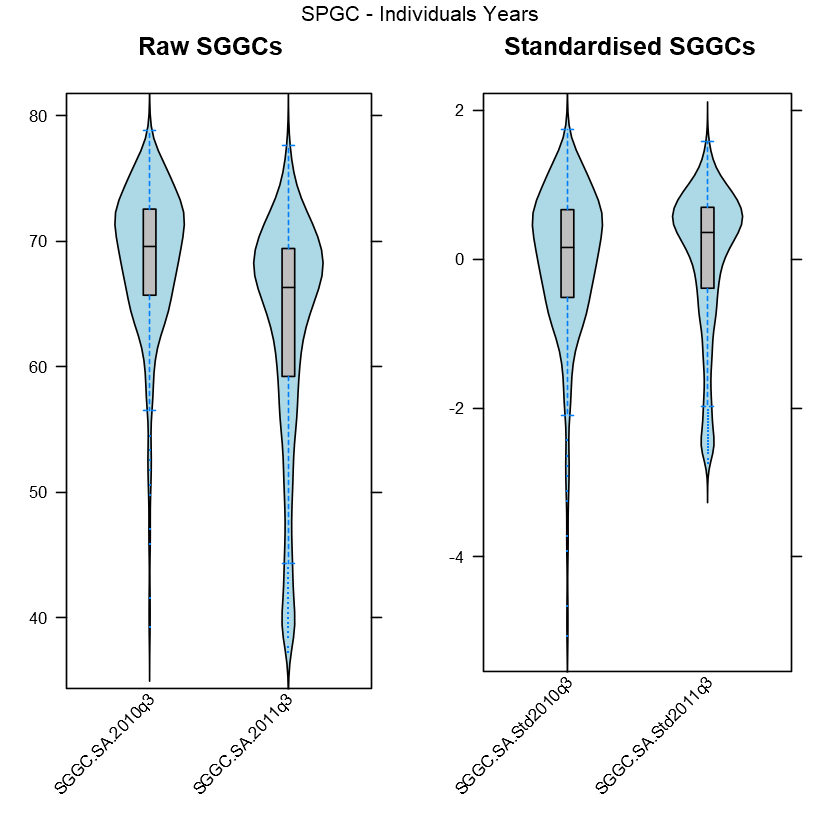

No id variables; using all as measure variables
No id variables; using all as measure variables
Warning message:
"Removed 120097 rows containing non-finite values (stat_density)."Warning message:
"Removed 60629 rows containing non-finite values (stat_density)."Warning message:
"Removed 120097 rows containing non-finite values (stat_density)."Warning message:
"Removed 60629 rows containing non-finite values (stat_density)."

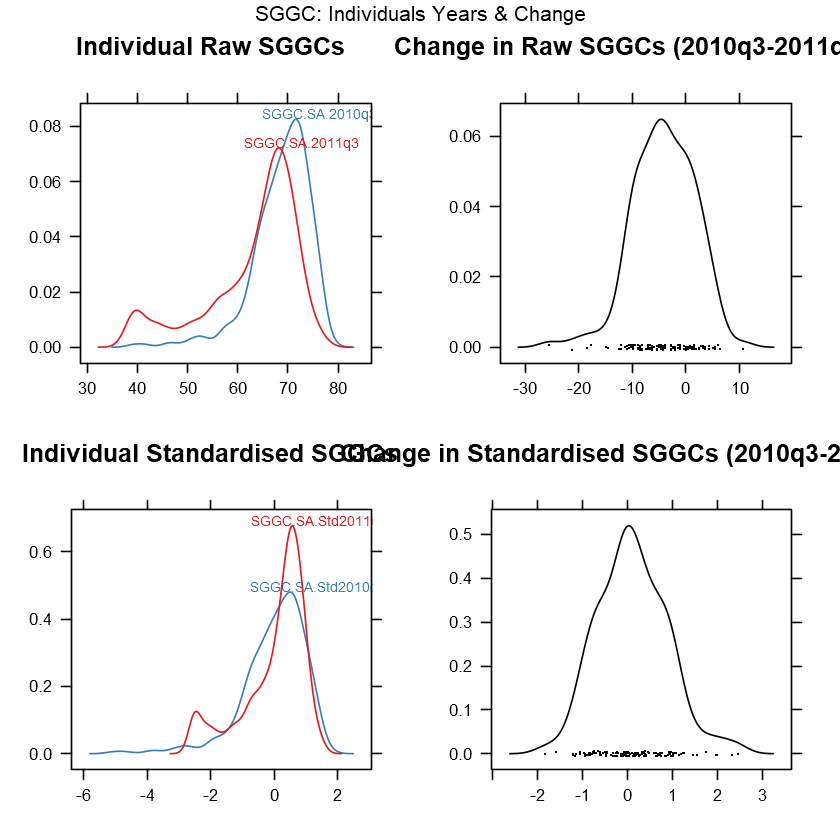

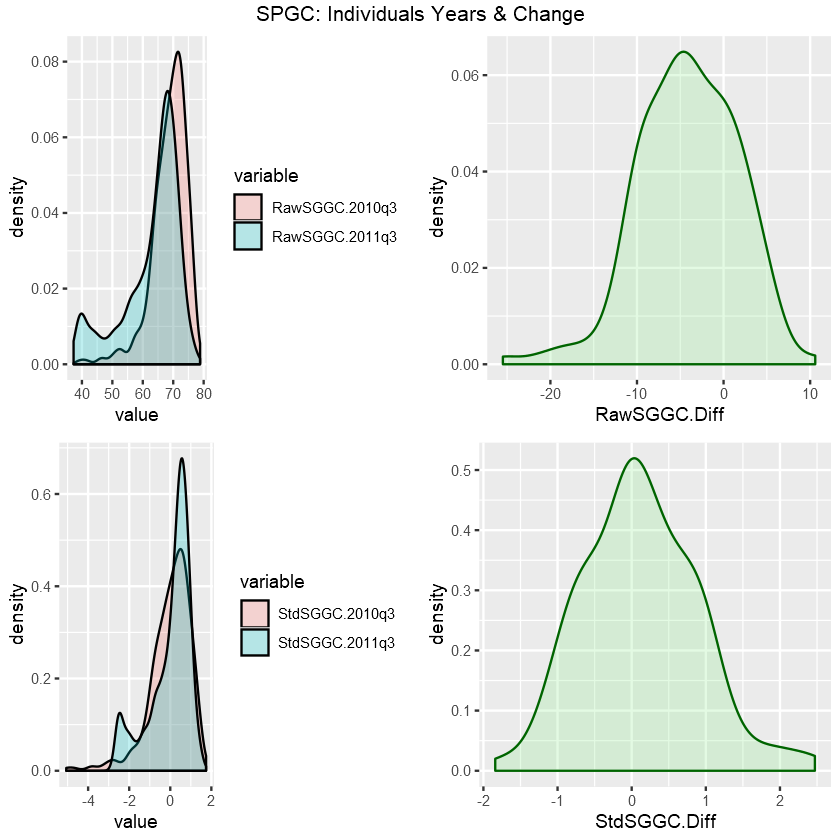

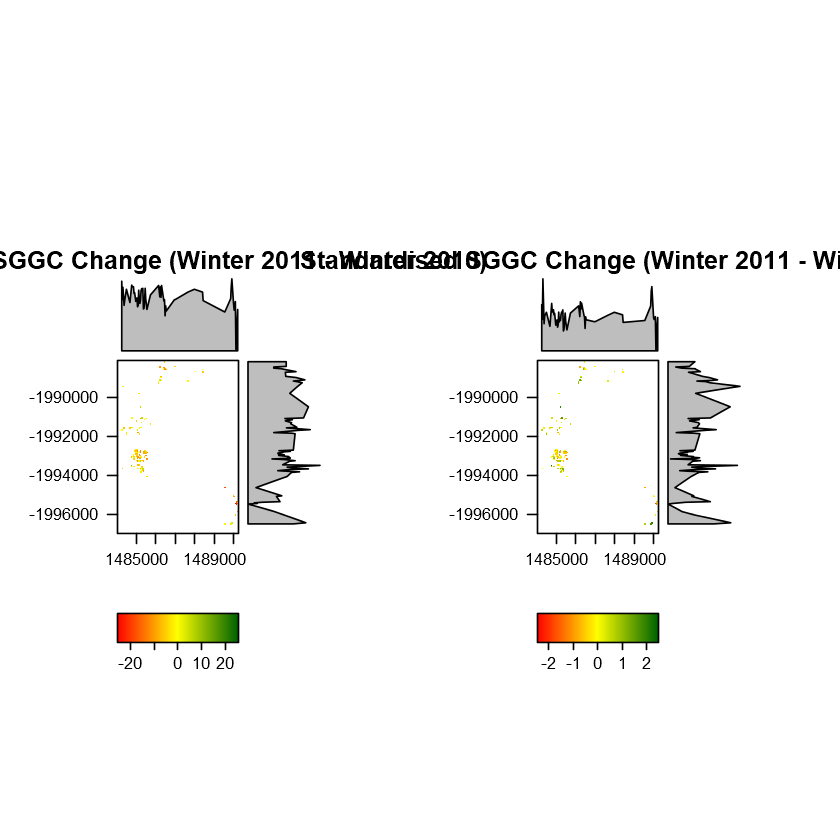

In [24]:
#========================================================================================================================
# Visualise Change in SGGC between Winter 2010 and Winter 2011
#========================================================================================================================
# We already have a rasterBrick with individuals raw (in %) raster layers (i.e. for 2010-Winter and 2011-Winter).
# We now need to create an analogous rasterBrick for the standardised (in SDs) raster layers.


# Create RasterBrick object with Standardised SGGC
# ------------------------------------------------
SGGC.StudyArea.Std2010q3_2011q3.rb = brick(normImage(SGGC.StudyArea.2010q3.rl), normImage(SGGC.StudyArea.2011q3.rl))
names(SGGC.StudyArea.Std2010q3_2011q3.rb) = c("SGGC.SA.Std2010q3", "SGGC.SA.Std2011q3")		  
SGGC.StudyArea.Std2010q3_2011q3.rb


#------------------------------------------------------------------------------------------------------------------------
# Boxplots
#------------------------------------------------------------------------------------------------------------------------

# Change in 'Raw' SGGC
# --------------------
RawSGGC.IndvYrs.bwplot = bwplot(SGGC.StudyArea.2010q3_2011q3.rb, main="Raw SGGCs")

# Change in Standardised SGGC
# ---------------------------
StdSGGC.IndvYrs.bwplot = bwplot(SGGC.StudyArea.Std2010q3_2011q3.rb, main="Standardised SGGCs")


#------------------------------------------------------------------------------------------------------------------------
# Scatter plots with loess
#------------------------------------------------------------------------------------------------------------------------
# NOTE: This type of plot does not work for SGGC due to the Missing Values

# Change in 'Raw' SGGC
# --------------------
RawSGGC.IndvYrs.splot = splom(SGGC.StudyArea.2010q3_2011q3.rb, plot.loess=TRUE, xlab='')

# Change in Standardised SGGC
# ---------------------------
StdSGGC.IndvYrs.splot = splom(SGGC.StudyArea.Std2010q3_2011q3.rb, main="Standardised SGGCs", plot.loess=TRUE, xlab='')


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Combine the 4 Plots in a single Graph
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Scatter plots do not work (see above)
#grid.arrange( RawSGGC.IndvYrs.bwplot, StdSGGC.IndvYrs.bwplot, 
#              RawSGGC.IndvYrs.splot, StdSGGC.IndvYrs.splot,
#              nrow=2, top="SPGC - Individuals Years" )

grid.arrange( RawSGGC.IndvYrs.bwplot, StdSGGC.IndvYrs.bwplot, 
              nrow=1, top="SPGC - Individuals Years" )


			  		  		  
#------------------------------------------------------------------------------------------------------------------------
# Density Plots
#------------------------------------------------------------------------------------------------------------------------

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Method 1: Using 'densityplot' from the package 'rasterVis`
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Change in 'Raw' SGGC
# --------------------
RawSGGC.IndvYrs.dp = densityplot(SGGC.StudyArea.2010q3_2011q3.rb, main="Individual Raw SGGCs")
RawSGGC.Diff.dp = densityplot(SGGC.StudyArea.Diffq3.rl, main="Change in Raw SGGCs (2010q3-2011q3)")

# Change in Standardised SGGC
# ---------------------------
StdSGGC.IndvYrs.dp = densityplot(SGGC.StudyArea.Std2010q3_2011q3.rb, main="Individual Standardised SGGCs")
StdSGGC.Diff.dp = densityplot(SGGC.StudyArea.StdDiffq3.rl, main="Change in Standardised SGGCs (2010q3-2011q3)")

# Combine 4 Plots in a Graph
# ~~~~~~~~~~~~~~~~~~~~~~~~~~
grid.arrange( RawSGGC.IndvYrs.dp, RawSGGC.Diff.dp, StdSGGC.IndvYrs.dp, StdSGGC.Diff.dp,
              nrow=2, top="SGGC: Individuals Years & Change" )
			  
	  
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Method 2: Using 'ggplot' from the package 'ggplot2`
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Create a DataFrame with the required values 
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Create a DataFrame with the required values to pass to function 'ggplot' in the package 'ggplot2' 
# Required values: SGGCs for 2010q3, 2011q3, and their difference in both scales: Raw and Standardised.
RawSGGC.2010q3 = values(SGGC.StudyArea.2010q3.rl)
RawSGGC.2011q3 = values(SGGC.StudyArea.2011q3.rl)
RawSGGC.Diff = values(SGGC.StudyArea.Diffq3.rl)
StdSGGC.2010q3 = values(normImage(SGGC.StudyArea.2010q3.rl))
StdSGGC.2011q3 = values(normImage(SGGC.StudyArea.2011q3.rl))
StdSGGC.Diff = values(SGGC.StudyArea.StdDiffq3.rl)
SGGCs.df = data.frame( RawSGGC.2010q3, RawSGGC.2011q3, RawSGGC.Diff, 
                       StdSGGC.2010q3, StdSGGC.2011q3, StdSGGC.Diff )
#summary(SGGCs.df)
                               

# Change in 'Raw' SGGC
# --------------------

# Density plot of Raw SGGC values for Individual Years 
# ....................................................
# Subset Dataset and convert wide format to long format
RawSGGC.IndvYrs.dflf = melt(SGGCs.df[c("RawSGGC.2010q3","RawSGGC.2011q3")])
RawSGGC.IndvYrs.dp2 = ggplot(RawSGGC.IndvYrs.dflf, aes(x=value, fill=variable)) +
                      geom_density(alpha=0.25)
                   
# Density plot of the change in Raw SGGC values
# ....................................................
RawSGGC.Diff.dp2 = ggplot(SGGCs.df, aes(x=RawSGGC.Diff)) + 
                   geom_density(alpha=0.25,color="darkgreen", fill="lightgreen")
                   

# Change in Standardised SGGC
# ---------------------------

# Density plot of Raw SGGC values for Individual Years 
# ....................................................
# Subset Dataset and convert wide format to long format
StdSGGC.IndvYrs.dflf = melt(SGGCs.df[c("StdSGGC.2010q3","StdSGGC.2011q3")])
StdSGGC.IndvYrs.dp2 = ggplot(StdSGGC.IndvYrs.dflf, aes(x=value, fill=variable)) +
                       geom_density(alpha=0.25)
                   
# Density plot of the change in Raw SGGC values
# ....................................................
StdSGGC.Diff.dp2 = ggplot(SGGCs.df, aes(x=StdSGGC.Diff)) + 
                    geom_density(alpha=0.25,color="darkgreen", fill="lightgreen")

                    
# Combine the 4 Plots in a single Graph
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
grid.arrange( RawSGGC.IndvYrs.dp2, RawSGGC.Diff.dp2, StdSGGC.IndvYrs.dp2, StdSGGC.Diff.dp2,
              nrow=2, top="SPGC: Individuals Years & Change" )

	  

#------------------------------------------------------------------------------------------------------------------------
# Rasters with Differences between both years (Raw & Standardised)
#------------------------------------------------------------------------------------------------------------------------
# They have very differnt scales (Raw SGGC and Standardised SGGC values)


# Change in Raw SGGC 
# -------------------
#SGGC.StudyArea.Diffq3.rl

# Create the color palette
# ........................
abs.max = max(abs(values(SGGC.StudyArea.Diffq3.rl)), na.rm=TRUE)
# Red: low SGGCs, Yellow: middle SGGCs; Green: high SGGCs (Darker Greens indicate Higher SGGCs)
RawSGGC.Diff.breaks = seq(-abs.max,abs.max, by=0.01)
RawSGGC.Diff.cols = colorRampPalette(c("red", "yellow", "darkgreen"))(length(RawSGGC.Diff.breaks)-1)

# Create Raster Plots with Density Plots
# ......................................
StudyArea.RawSGGCDiff.p = levelplot( SGGC.StudyArea.Diffq3.rl, at=RawSGGC.Diff.breaks, 
                                     col.regions=RawSGGC.Diff.cols, main="Raw SGGC Change (Winter 2011 - Winter 2010)" )                               
                                   

# Change in Standardised SGGC
# ---------------------------
#SGGC.StudyArea.StdDiffq3.rl

# Create the color palette
# ........................
abs.max = max(abs(values(SGGC.StudyArea.StdDiffq3.rl)), na.rm=TRUE)
# Red: low SGGCs, Yellow: middle SGGCs; Green: high SGGCs (Darker Greens indicate Higher SGGCs)
StdSGGC.Diff.breaks = seq(-abs.max,abs.max, by=0.01)
StdSGGC.Diff.cols = colorRampPalette(c("red", "yellow", "darkgreen"))(length(StdSGGC.Diff.breaks)-1)

                            
# Create Raster Plots with Density Plots
# ......................................
StudyArea.StdSGGCDiff.p = levelplot(SGGC.StudyArea.StdDiffq3.rl, at=StdSGGC.Diff.breaks, 
                                     col.regions=StdSGGC.Diff.cols, main="Standardised SGGC Change (Winter 2011 - Winter 2010)")
                            

# Plot Raster Plots
# ~~~~~~~~~~~~~~~~~
# `grid.arrange` provides multiple plots per page. They look good on screen, 
# but might be too small in the Workshop/Tutorial report. 

# Plot Raw & Standardised Change in SGGC from the Winter of 2010 to the Winter of 2011
grid.arrange(StudyArea.RawSGGCDiff.p, StudyArea.StdSGGCDiff.p, nrow=1)

# Create individual plots of SPGC rasters for both years (previously both years graphed in a single plot)
SA.SGGC.2010q3.p = levelplot(SGGC.StudyArea.2010q3.rl, at=SGGC.breaks, col.regions=SGGC.cols, main="Seasonal Persistent Green Cover (2010-Winter)")
SA.SGGC.2011q3.p = levelplot(SGGC.StudyArea.2011q3.rl, at=SGGC.breaks, col.regions=SGGC.cols, main="Seasonal Persistent Green Cover (2011-Winter)")
## Plot Raw Values (top row) + Raw & Standardised Change (bottom row)
#grid.arrange(SA.SGGC.2010q3.p, SA.SGGC.2011q3.p, StudyArea.RawSGGCDiff.p, StudyArea.StdSGGCDiff.p, nrow=2)


## Results Interpretation

Numerical and graphical exploration of the percentage difference rasters indicate a very small increase (mean=0.7%, median=0.4%) in SPGC and decrease in SGGC (mean=-4.2%, median=-4.3%) between the winters of 2010 and 2011. For individual cells the percentage difference in SPGC between both winters ranges from a decrease of ~7.8% to an increase of ~7.1%. Individual cells percentage difference in SGGC has a much wider range (from -25.5% to ~10.6%).

To investigate where the changes in SPGC and SGGC occurred within the Djiru National Park we compare the Raster Images with a Stamen Map of the Study Area. The Stamen Map and the Rasters have different CRSs. The former is in a general world CRS (EPSG:4326 =  'WGS 84') and the latter in an Australian-specific CRS (EPSG:3577= 'GDA94' = 'Australian Albers'). The Stamen Map cannot be reprojected as it is a map image. Thus, we reproject the rasters and create new plots of these reprojected rasters. The effects of the reprojection can be clearly seen in the SPGC rasters. In the SGGC rasters the large number of missing values (i.e. cells with NA values), which are plotted on white, precludes us from clearly seeing the reprojection effect. 

Examination of the difference SPGC raster reveals that the majority of the increase happens in the North-West third of the study area. In the remaining areas, much smaller pockets of decrease and increase in Green Cover are intermixed. To investigate the causes of these results we download and plot a Stamen map of the Study Area (i.e. more detailed than the Region area map plot above). It seems that most of the increase in SPGC has occurred to the west of mountainous section of the study area. The increase in trees and bushes cover in this section could be larger precipitation in the wet season, while being protected from the destructive effect of the cyclone by a number of factors. These factors could include topography (i.e. cover located in the leeward side and valleys), and differences in vegetation composition and/or structure. The effect of topology could be assessed by obtaining a topology or digital elevation model raster (or shapefile), calculate metrics such as elevation, slope, aspect, as well as distance and orientation relative to the mountain ridges, and relating (e.g. using Spearman's rank correlation or a model) these to the change in SPGC. 

The raster for the difference in SGGC only shows very few and small pockets of SGGC change. The reason for the small number of areas of change is that there are only a small proportion of cells with SGGC values (and a large proportion with missing values), as SGGC is only estimated for cells where green cover by woody vegetation is less than 60% and there are not many of these cells in the Study Area. In most of these more open sections, individual cells SGGC modestly decreased (maximum decrease of ~25.5%). However, it is likely that the decrease in SGGC was larger immediately after the cyclone landfall, and that SGGC has recovered in the subsequent half a year.


Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.


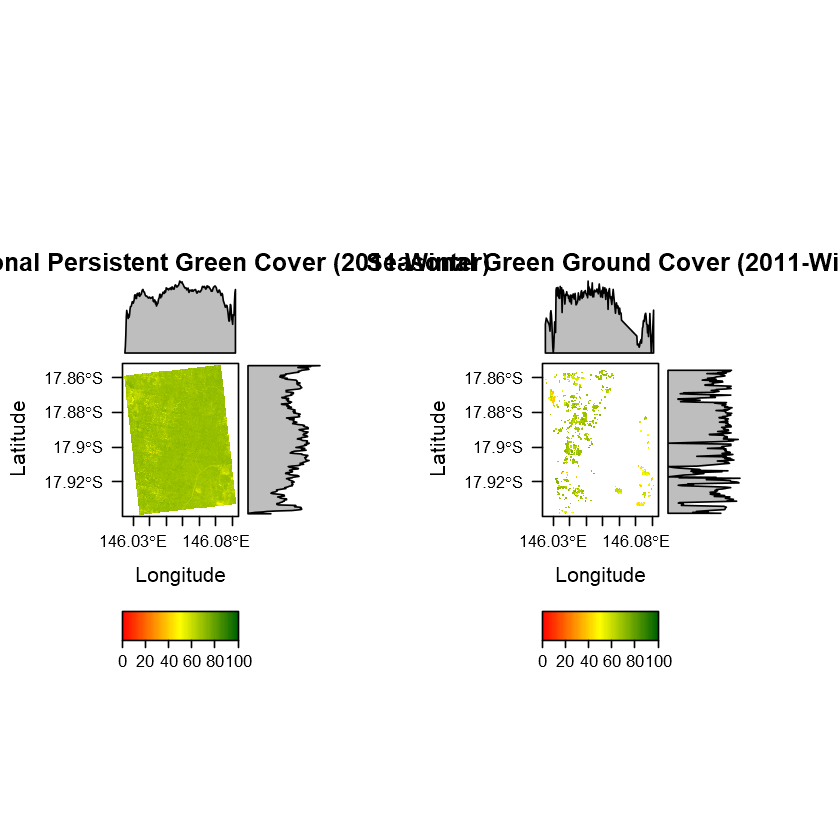

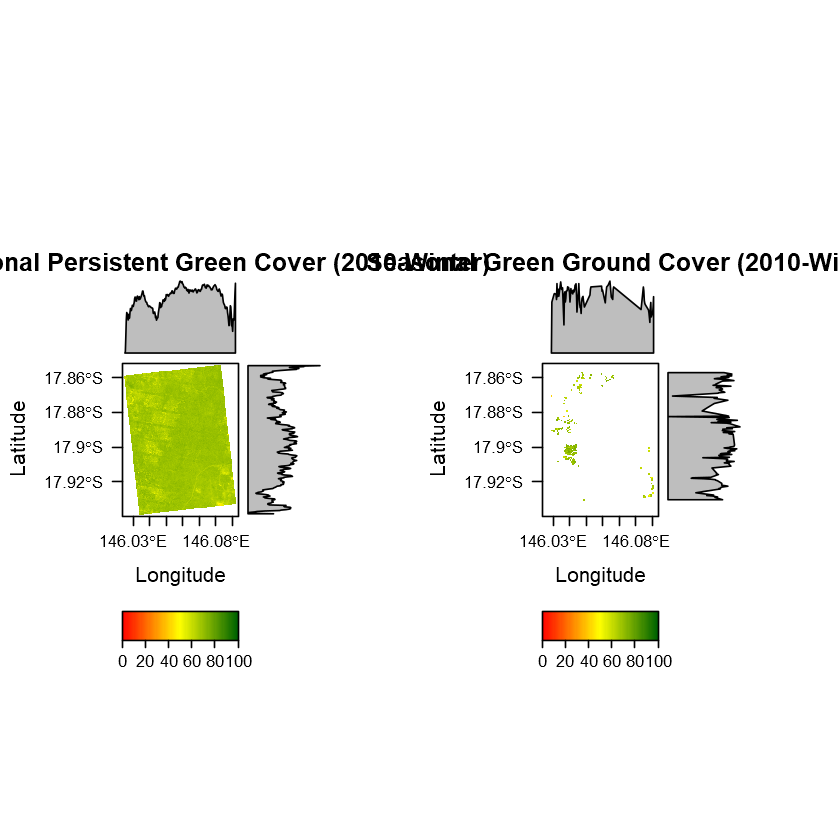

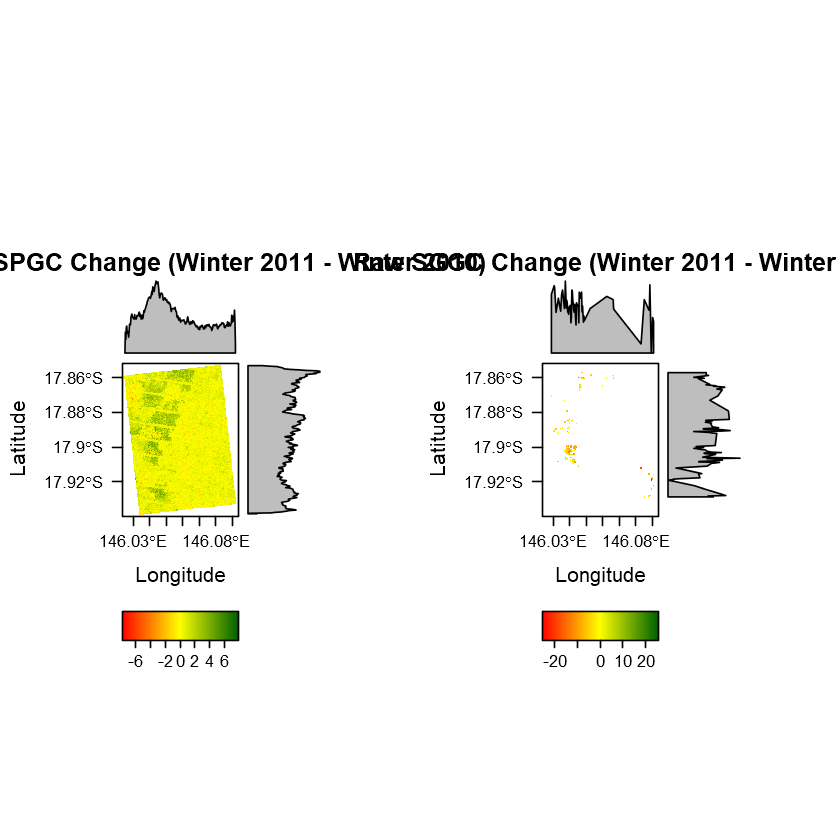

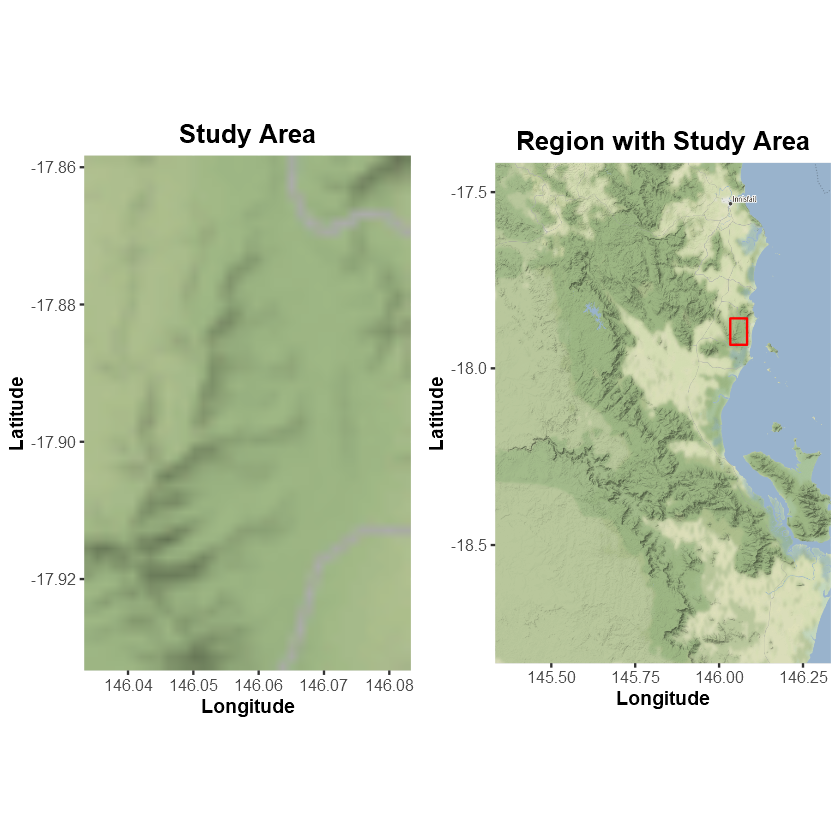

In [25]:
#************************************************************************************************************************
# Results Interpretation
#************************************************************************************************************************

# Reproject Rasters to EPSG:4326 (general spatial CRS with coordinates on the WGS84 datum on the Stamen Maps)
# -----------------------------------------------------------------------------------------------------------
# SPGC Study Area 2010 Winter
SPGC.StudyArea.2010q3.reprj.rl = projectRaster(SPGC.StudyArea.2010q3.rl, crs=CRS("+init=epsg:4326"))
# SPGC Study Area 20101Winter
SPGC.StudyArea.2011q3.reprj.rl = projectRaster(SPGC.StudyArea.2011q3.rl, crs=CRS("+init=epsg:4326"))
# SGGC Study Area 2010 Winter
SGGC.StudyArea.2010q3.reprj.rl = projectRaster(SGGC.StudyArea.2010q3.rl, crs=CRS("+init=epsg:4326"))
# SGGC Study Area 2011 Winter
SGGC.StudyArea.2011q3.reprj.rl = projectRaster(SGGC.StudyArea.2011q3.rl, crs=CRS("+init=epsg:4326"))
# SPGC Study Area Difference between Winters of 2011 and 2010
SPGC.StudyArea.Diffq3.reprj.rl = projectRaster(SPGC.StudyArea.Diffq3.rl, crs=CRS("+init=epsg:4326"))
# SGGC Study Area Difference between Winters of 2011 and 2010
SGGC.StudyArea.Diffq3.reprj.rl = projectRaster(SGGC.StudyArea.Diffq3.rl, crs=CRS("+init=epsg:4326"))

# Create Plots of the Reprojected Rasters
# ---------------------------------------
# SPGC Study Area 2010 Winter
SA.SPGC.2011q3.reprj.p = levelplot(SPGC.StudyArea.2010q3.reprj.rl, at=SGGC.breaks, col.regions=SGGC.cols, 
                                   main="Seasonal Persistent Green Cover (2010-Winter)")
# SPGC Study Area 2011 Winter
SA.SPGC.2010q3.reprj.p = levelplot(SPGC.StudyArea.2011q3.reprj.rl, at=SGGC.breaks, col.regions=SGGC.cols, 
                                   main="Seasonal Persistent Green Cover (2011-Winter)")
# SGGC Study Area 2010 Winter
SA.SGGC.2011q3.reprj.p = levelplot(SGGC.StudyArea.2010q3.reprj.rl, at=SGGC.breaks, col.regions=SGGC.cols, 
                                   main="Seasonal Green Ground Cover (2010-Winter)")
# SGGC Study Area 2011 Winter
SA.SGGC.2010q3.reprj.p = levelplot(SGGC.StudyArea.2011q3.reprj.rl, at=SGGC.breaks, col.regions=SGGC.cols, 
                                   main="Seasonal Green Ground Cover (2011-Winter)")
# SPGC Study Area Difference between Winters of 2011 and 2010
StudyArea.RawSPGCDiff.reprj.p = levelplot(SPGC.StudyArea.Diffq3.reprj.rl, at=RawSPGC.Diff.breaks, col.regions=RawSPGC.Diff.cols, 
                                          main="Raw SPGC Change (Winter 2011 - Winter 2010)")
# SGGC Study Area Difference between Winters of 2011 and 2010
StudyArea.RawSGGCDiff.reprj.p = levelplot(SGGC.StudyArea.Diffq3.reprj.rl, at=RawSGGC.Diff.breaks, col.regions=RawSGGC.Diff.cols, 
                                          main="Raw SGGC Change (Winter 2011 - Winter 2010)")

										  
# Get Map
# -------
# get_stamenmap requires the coordinates in a different order than the extent construction
StudyArea.StamenMap = get_stamenmap(StudyArea.extent[c(1,3,2,4)], maptype="terrain")

# Create Plot of the Map
# ----------------------
# Stamen map of this area is not very detailed
StudyArea.p = 
ggmap(StudyArea.StamenMap) + labs(title= "Study Area", x="Longitude", y="Latitude") +
theme(plot.title = element_text(hjust = 0.5, size=15, face="bold"), 
      axis.title = element_text(size=11, face="bold"), axis.text=element_text(size=9) )

	  
# Plot Results and Map
# --------------------
# Plot Raw SPGC & Raw SGGC for the Winter of 2010
grid.arrange(SA.SPGC.2010q3.reprj.p, SA.SGGC.2010q3.reprj.p, nrow=1)
# Plot Raw SPGC & Raw SGGC for the Winter of 2011
grid.arrange(SA.SPGC.2011q3.reprj.p, SA.SGGC.2011q3.reprj.p, nrow=1)
# Plot Differences in Raw SPGC & Raw SGGC between the Winters of 2011 and 2010
grid.arrange(StudyArea.RawSPGCDiff.reprj.p, StudyArea.RawSGGCDiff.reprj.p, nrow=1)
# Plot Region & Study Area
grid.arrange(StudyArea.p, RegionwStudyArea.p, nrow=1)


## Save Results: Write Rasters to a File

Two functions of the package `raster` can be used to write raster to a file:

* `writeRaster`:  Writes an entire Raster* object to a file in a supported format.
* `writeValues`: Writes chucks (e.g. by row) of a Raster* object to a file in a supported format.


Supported formats include (in parenthesis is the file extension for the format):

* Native `raster` package format (.grd): It conserves the original file names in the individual band names.
* netCDF (.nc): Requires the library `ncdf4`.
* GeoTiff (.tif): Requires the library `rgdal`.
* ENVI .hdr labelled (.envi),
* ESRI hdr. labelled (.bil)
* Erdas Imagine Images (.img)
* ESRI ASCII (.asc)
* SAGA GIS (.sdat), 
* IDRISI (.rst).

The native `raster` package (`.grd`) format preserves the layer names, but raster grid binary files are not compressed. The native `raster` package format consists of two files: (1) `.gri` binary file, and (2) `.grd` header file. This is enough to open the files in R. However, to open raster grid files in most GIS software packages you will need to write an additional hearder file. The 'ENVI' header format usually works fine. It creates two additional files, a `.hdr` file and a `.stx` files. The statistics file (`.stx`) is an optional file that describes image statistics for each spectral band in a grayscale or multiband image. The file consists of a series of entries, one for each band, that records the minimum pixel value, the maximum pixel value, the mean, the standard deviation, and two linear contrast stretch parameters. To open a saved raster in, for example QGIS, select the '.gri' binary file. An example of how to create a header file in 'ENVI' format is provided below. 

Other formats than the native `raster` packge (`.grd`) format do not preserve the layer names (but you could always save the layers individually). Currently, the files saved in netCDF format do not contain CRS information ("coord. ref.: NA"). The last 3 formats cannot store Multi-band rasters. For further details see help on 'writeRaster' and 'writeFormat'. 


If argument `prj` is TRUE, the CRS is written to a '.prj' file. This can be useful when writing to a file type that does not store the crs, such as ASCII files. 

For multi-layer rasters (RasterStack and RasterBrick objects), individual layers can be stored in the same file or in separate files. When argument `bylayer` is TRUE, layers are saved to separate files. In this case, to name the separate files the user provide naming directions using the argument `suffix`. The user can provide: 

* A vector with filenames, with as many file names as layers (i.e. names(x))
* A single filename that will get a unique suffix (i.e. a number between 1 and nlayers(x))


In [26]:
#************************************************************************************************************************
# Save Results: Saving Rasters
#************************************************************************************************************************

# Make a Raster Brick with all the Layers we want to save
# -------------------------------------------------------
ls(pattern="\\.rl$")
SGC.StudyArea.Res.rb = brick(SPGC.StudyArea.2010q3.rl, SPGC.StudyArea.2011q3.rl, 
							 SPGC.StudyArea.Diffq3.rl, SPGC.StudyArea.StdDiffq3.rl, 
							 SGGC.StudyArea.2010q3.rl, SGGC.StudyArea.2011q3.rl, 
							 SGGC.StudyArea.Diffq3.rl, SGGC.StudyArea.StdDiffq3.rl)
names(SGC.StudyArea.Res.rb) = c("SPGC_StudyArea_2010Winter", "SPGC_StudyArea_2011Winter", "SPGC_StudyArea_Diff", "SPGC_StudyArea_StdDiff", 
								"SGGC_StudyArea_2010Winter", "SGGC_StudyArea_2011Winter", "SGGC_StudyArea_Diff", "SGGC_StudyArea_StdDiff")		  
SGC.StudyArea.Res.rb							  


# Save RasterBrick in native 'raster' package format for 'external' use
# ---------------------------------------------------------------------
# It will preserve the Layer Names, but raster grid binary files are not compressed.
# Creates two files: (1) '.gri' binary file, and (2) '.grd' header file.

# Save Raster for Internal R consumption 
writeRaster(SGC.StudyArea.Res.rb, "SGC_StudyArea_Res.grd", format="raster", overwrite=TRUE)
list.files(pattern="SGC_StudyArea_Res")


# Save RasterBrick in native 'raster' package format for 'external' use
# ---------------------------------------------------------------------
# Save Raster to be opened in a GIS software package. It must include an adequate Header Files,
# here we use an 'ENVI' header file 
raster.grid = writeRaster(SGC.StudyArea.Res.rb, "SGC_StudyArea_Res.grd", format="raster", overwrite=TRUE)
class(raster.grid)
hdr(raster.grid, format="ENVI")
list.files(pattern="SGC_StudyArea_Res")


# Save RasterBrick in formats other than the native 'raster' package format
# -------------------------------------------------------------------------
# Other formats will not preserve the Layer Names (but could always save the layers individually)

# Save raster in 'netCDF' format (requires the library 'ncdf4') 
writeRaster(SGC.StudyArea.Res.rb, "SGC_StudyArea_Res.nc", format="CDF", overwrite=TRUE)


# Check Contents and Layers Names of the Saved Raster Files & Delete unwanted Files
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
check.nc.rb = brick("SGC_StudyArea_Res.nc")
check.nc.rb
check.grd.rb = brick("SGC_StudyArea_Res.grd")
check.grd.rb
rm(list=ls(pattern="check"))


[1] "SGGC.2010q3.rl"                 "SGGC.2011q3.rl"                
 [3] "SGGC.StudyArea.2010q3.reprj.rl" "SGGC.StudyArea.2010q3.rl"      
 [5] "SGGC.StudyArea.2011q3.reprj.rl" "SGGC.StudyArea.2011q3.rl"      
 [7] "SGGC.StudyArea.Diffq3.reprj.rl" "SGGC.StudyArea.Diffq3.rl"      
 [9] "SGGC.StudyArea.StdDiffq3.rl"    "SPGC.2010q3.rl"                
[11] "SPGC.2011q3.rl"                 "SPGC.StudyArea.2010q3.reprj.rl"
[13] "SPGC.StudyArea.2010q3.rl"       "SPGC.StudyArea.2011q3.reprj.rl"
[15] "SPGC.StudyArea.2011q3.rl"       "SPGC.StudyArea.Diffq3.reprj.rl"
[17] "SPGC.StudyArea.Diffq3.rl"       "SPGC.StudyArea.StdDiffq3.rl"

class       : RasterBrick 
dimensions  : 295, 206, 60770, 8  (nrow, ncol, ncell, nlayers)
resolution  : 30, 30  (x, y)
extent      : 1484025, 1490205, -1996985, -1988135  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : SPGC_StudyArea_2010Winter, SPGC_StudyArea_2011Winter, SPGC_StudyArea_Diff, SPGC_StudyArea_StdDiff, SGGC_StudyArea_2010Winter, SGGC_StudyArea_2011Winter, SGGC_StudyArea_Diff, SGGC_StudyArea_StdDiff 
min values  :                 39.215686,                 39.215686,           -7.843137,              -3.245601,                 39.215686,                 37.254902,          -25.490196,              -1.840595 
max values  :                 77.254902,                 76.862745,            7.058824,               2.273073,                 78.823529,                 77.647059,           10.588235,               2.470940 


[1] "SGC_StudyArea_Res.grd" "SGC_StudyArea_Res.gri" "SGC_StudyArea_Res.hdr"
[4] "SGC_StudyArea_Res.nc"  "SGC_StudyArea_Res.stx"

[1] "RasterBrick"
attr(,"package")
[1] "raster"

[1] "SGC_StudyArea_Res.grd" "SGC_StudyArea_Res.gri" "SGC_StudyArea_Res.hdr"
[4] "SGC_StudyArea_Res.nc"  "SGC_StudyArea_Res.stx"

Loading required namespace: ncdf4


class       : RasterBrick 
dimensions  : 295, 206, 60770, 8  (nrow, ncol, ncell, nlayers)
resolution  : 30, 30  (x, y)
extent      : 1484025, 1490205, -1996985, -1988135  (xmin, xmax, ymin, ymax)
coord. ref. : NA 
data source : C:/Users/uqbblanc/Documents/TERN/04b-DSDP_GitHub/Prep/Landscapes_AusCover-RemoteSensing/YasiEffectsonGCatMB/YasiEffectsonGCatMB_Tutorial/SGC_StudyArea_Res.nc 
names       : X1, X2, X3, X4, X5, X6, X7, X8 
unknown     : 1, 2, 3, 4, 5, 6, 7, 8 
varname     : variable 


class       : RasterBrick 
dimensions  : 295, 206, 60770, 8  (nrow, ncol, ncell, nlayers)
resolution  : 30, 30  (x, y)
extent      : 1484025, 1490205, -1996985, -1988135  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : C:/Users/uqbblanc/Documents/TERN/04b-DSDP_GitHub/Prep/Landscapes_AusCover-RemoteSensing/YasiEffectsonGCatMB/YasiEffectsonGCatMB_Tutorial/SGC_StudyArea_Res.grd 
names       : SPGC_StudyArea_2010Winter, SPGC_StudyArea_2011Winter, SPGC_StudyArea_Diff, SPGC_StudyArea_StdDiff, SGGC_StudyArea_2010Winter, SGGC_StudyArea_2011Winter, SGGC_StudyArea_Diff, SGGC_StudyArea_StdDiff 
min values  :                 39.215686,                 39.215686,           -7.843137,              -3.245601,                 39.215686,                 37.254902,          -25.490196,              -1.840595 
max values  :                 77.254902,                 76.862745,            7.058824,      